<div align="center">

# **Optimisations Par Descente De Gradient,Effet Du Learning-Rate** 

# **Et Du Batch-Size Sur La Convergence**

</div>
<br><br>
<br><br>
<br><br>

## **Introduction**

Ce premier Bloc de travail portera sur les optimisations pour la fonction de régression logistique. Il est composé de trois parties. 

Une première partie sera consacréé à la présentation et l'implémentation des algorithmes d'optimisation usuels pour la fonction de perte "cross-entropy binaire".

La deuxième et troisième partie traiteront respectivement de l'influence de l'hyperparamètre "Learning-rate" et l'hyperparamètre "Batch-size" sur la convergence de ces algorithmes.

Commençons par un petit rappel du formalisme mathématique de la fonction de **cross-entropy binaire**:

Soient :

$m$ le nombre d'exemples d'entraînement

$x^{(i)}$ le vecteur des caractéristiques pour le i-ème exemple

$y^{(i)}$ l'étiquette (0 ou 1) pour le i-ème exemple

$\hat{y}^{(i)}$ la prédiction du modèle pour le i-ème exemple

$\theta$ le vecteur des paramètres du modèle

La fonction de perte $J(\theta)$ est définie comme suit :
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)}) \right]$$
où :
$$\hat{y}^{(i)} = h_\theta(x^{(i)}) = \frac{1}{1 + e^{-\theta^T x^{(i)}}}$$
Cette dernière équation est la fonction sigmoïde (ou logistique) appliquée au produit scalaire entre $\theta$ et $x^{(i)}$.
L'objectif de l'apprentissage est de minimiser cette fonction de perte par rapport aux paramètres $\theta$.
La dérivée partielle de la fonction de perte par rapport à un paramètre $\theta_j$ est :
$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m (\hat{y}^{(i)} - y^{(i)}) x_j^{(i)}$$
Cette dérivée est utilisée dans l'algorithme de descente de gradient pour mettre à jour les paramètres :
$$\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}$$
où $\alpha$ est le pas d'apprentissage.

Cette fonction est **Lisse** et **Convexe**, deux proprietés importantes pour les optimisations à venir. La démonstration mathématique de ces deux proprietés est étayée en Annexe-1.


Dans la suite, l'implémentation de quelques fonctions nécéssaires à la régression logistique, et la génération des données :


In [4]:
# Implémentation de quelques préalables:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
np.random.seed(1337)

## Définir un set de données adapté à la régression logistique inspiré de l'exemple donné

# Paramètres

m, n = 1000, 100  # m échantillons, n caractéristiques

# Générer des données synthétiques: données d'entrée, coeffs et bruit ajouté

X = np.random.normal(0, 1, (m, n)) # On garde une forme sans colonne de biais, c'est un choix pour l'implémentation
X_with_bias = np.hstack([np.ones((m, 1)), X]) # pour bien faire le distingo avec un tableau de données X, qui ne contient pas de colonne biais
w_opt = np.random.normal(0, 1, n+1) # incluant un biais, d'ou le n+1
noise = np.random.normal(0, 0.1, m) # on reste sur le même type de bruit que l'exemple

# Obtention des labels à partir des coeffs générés et définis optimaux

z = X_with_bias.dot(w_opt) + noise # score brut et bruité (logits)
p = 1 / (1 + np.exp(-z))  # Probabilités en sortie de la fonction logistique
y =  y = (p >= 0.5).astype(int) # conversion en étiquettes binaires


## Quelques fonctions dont nous auront besoin dans l'implémentation

# La fonction logistique pour convertir en probabilité la combinaison linéaire des entrées

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Fonction pour initialiser un vecteur de poids de départ ( au hasard, empiriquement efficace)

def random_initialize_parameters(n_features):
    return np.random.randn(n_features + 1)

# Fonction pour prédire la probabilité de l'appartenance à la classe 1 des observations

def predict(X, w):
    return sigmoid(np.dot(X, w[1:]) + w[0])

# Fonction pour calculer la perte logistique, definie en tant que binary cross entropy loss dans ce cas

def cost_function(X, y, w, epsilon=1e-8): # notons le rajout d'un petit epsilon pour éviter les divisions par zéro
    y_pred = predict(X, w)
    cost = - (1 / len(y)) * np.sum(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    return cost




## **I- Implémentation des variantes incontournables de la descente de Gradient**

### **1- Descente de gradient simple**



In [7]:
# Implémantation de descente de gradient simple:
def gradient_descent(X, y, w_random, learning_rate, num_iterations):
    """
    Implémente l'algorithme de descente de gradient pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons par n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    num_iterations : nombre d'itérations pour l'algorithme

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à chaque itération
    """
    m = len(y)  # Nombre d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser

    for i in range(num_iterations):
        # Calcul des prédictions avec les poids actuels
        y_pred = predict(X, w)
        
        # Calcul du gradient pour les poids (sauf le biais)
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        # Calcul du gradient pour le biais
        db = (1/m) * np.sum(y_pred - y)
        
        # Mise à jour des poids (sauf le biais) avec la règle de descente de gradient
        w[1:] -= learning_rate * dw
        # Mise à jour du biais
        w[0] -= learning_rate * db
        
        # Calcul et stockage du coût pour cette itération
        cost = cost_function(X, y, w)
        costs.append(cost) 
    return w, costs

### **2- Descente de gradient stochastique avec taille de batch paramétrable**

In [9]:
# Implémentation de la descente de gradient stochastique, extensible en changeant la taille du batch:

def stochastic_gradient_descent(X, y, w_random, learning_rate, num_epochs, batch_size=1):
    """
    Implémente l'algorithme de descente de gradient stochastique pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    num_epochs : nombre d'époques (passages complets sur les données)
    batch_size : taille des mini-batchs (1 pour SGD pur, >1 pour mini-batch SGD)

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à intervalles réguliers
    """
    m = len(y)  # Nombre total d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser

    for epoch in range(num_epochs):
        # Mélange aléatoire des indices des échantillons
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Parcours des mini-batchs
        for i in range(0, m, batch_size):
            # Sélection du mini-batch courant
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # Calcul des prédictions pour le mini-batch
            y_pred = predict(X_batch, w)

            # Calcul du gradient pour les poids (sauf le biais) sur le mini-batch
            dw = (1/batch_size) * np.dot(X_batch.T, (y_pred - y_batch))
            # Calcul du gradient pour le biais sur le mini-batch
            db = (1/batch_size) * np.sum(y_pred - y_batch)

            # Mise à jour des poids (sauf le biais)
            w[1:] -= learning_rate * dw
            # Mise à jour du biais
            w[0] -= learning_rate * db

            # Calcul et stockage du coût
            cost = cost_function(X, y, w)
            costs.append(cost)

    return w, costs

### **3- Descente de Gradient avec Momentum**

La méthode de descente de gradient avec Momentum est une amélioration de la descente de gradient standard qui vise à accélérer la convergence et à réduire les oscillations. Voici le formalisme mathématique qui sous-tend cette méthode :

Soient :

$\theta_t$ les paramètres du modèle au temps t

$\nabla J(\theta_t)$ le gradient de la fonction de coût par rapport aux paramètres au temps t

$v_t$ la vélocité au temps t

$\gamma$ le coefficient de momentum (généralement autour de 0.9)

$\eta$ le taux d'apprentissage

Les équations de mise à jour pour la descente de gradient avec Momentum sont :

Mise à jour de la vélocité :
$$v_t = \gamma v_{t-1} + \eta \nabla J(\theta_t)$$

Mise à jour des paramètres :
$$\theta_{t+1} = \theta_t - v_t$$

Dans le contexte de la régression logistique, le gradient $\nabla J(\theta)$ est donné par :
$$\nabla J(\theta) = \frac{1}{m} X^T (\hat{y} - y)$$

où $\hat{y} = \sigma(X\theta)$ et $\sigma$ est la fonction sigmoïde.

L'intuition derrière le Momentum est qu'il agit comme une "boule" roulant le long de la surface de la fonction de coût. La vélocité s'accumule dans les directions qui persistent d'une itération à l'autre, ce qui aide à accélérer la convergence et à surmonter les petits obstacles locaux.


In [11]:
# Implémentation de la descente de gradient avec Momentum:

def gradient_descent_momentum(X, y, w_random, learning_rate, num_iterations, momentum=0.9):
    """
    Implémente l'algorithme de descente de gradient avec Momentum pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    num_iterations : nombre d'itérations pour l'algorithme
    momentum : coefficient de momentum (par défaut 0.9)

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à chaque itération
    """
    m = len(y)  # Nombre d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    velocity = np.zeros_like(w)  # Initialisation de la vélocité
    
    
    for i in range(num_iterations):
        # Calcul des prédictions avec les poids actuels
        y_pred = predict(X, w)
        
        # Calcul du gradient
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Mise à jour de la vélocité
        velocity[1:] = momentum * velocity[1:] + learning_rate * dw
        velocity[0] = momentum * velocity[0] + learning_rate * db
        
        # Mise à jour des poids avec la vélocité
        w[1:] -= velocity[1:]
        w[0] -= velocity[0]
        
        # Calcul et stockage du coût pour cette itération
        cost = cost_function(X, y, w)
        costs.append(cost)    
    return w, costs

### **4- Descente de Gradient avec la méthode de Nesterov ( NAG )**

La méthode de Nesterov, ou Nesterov Accelerated Gradient (NAG), est une amélioration de la descente de gradient avec Momentum. Elle offre une meilleure convergence en "anticipant" la position future des paramètres. Voici le formalisme mathématique de cette méthode :

Soient :

$\theta_t$ les paramètres du modèle au temps t

$\nabla J(\theta)$ le gradient de la fonction de coût par rapport aux paramètres

$v_t$ la vélocité au temps t

$\gamma$ le coefficient de momentum (généralement autour de 0.9)

$\eta$ le taux d'apprentissage

Les équations de mise à jour pour la méthode de Nesterov sont :

Calcul de la position "anticipée" :

$$\tilde{\theta_t} = \theta_t + \gamma v_{t-1}$$

Calcul du gradient à la position anticipée :

$$g_t = \nabla J(\tilde{\theta_t})$$

Mise à jour de la vélocité :

$$v_t = \gamma v_{t-1} + \eta g_t$$

Mise à jour des paramètres :

$$\theta_{t+1} = \theta_t - v_t$$

Dans le contexte de la régression logistique, le gradient $\nabla J(\theta)$ est calculé de la même manière que pour le Momentum standard, mais à la position anticipée $\tilde{\theta_t}$.

L'intuition derrière la méthode de Nesterov est qu'elle effectue une correction du gradient basée sur la position future estimée des paramètres, ce qui permet une convergence plus rapide et plus stable que le Momentum standard.



In [13]:
# Implémentation de la descente de gradient avec la méthode de Nesterov:
def gradient_descent_nesterov(X, y, w_random, learning_rate, num_iterations, momentum=0.9):
    """
    Implémente l'algorithme de descente de gradient avec la méthode de Nesterov pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    num_iterations : nombre d'itérations pour l'algorithme
    momentum : coefficient de momentum (par défaut 0.9)

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à chaque itération
    """

    m, n = X.shape
    costs = []
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    velocity = np.zeros_like(w)
    
    for i in range(num_iterations):
        # Calcul de la position anticipée
        w_ahead = w + momentum * velocity
        
        # Calcul du gradient à la position anticipée
        y_pred_ahead = predict(X, w_ahead)
        gradient_ahead = np.zeros_like(w)
        gradient_ahead[1:] = (1/m) * np.dot(X.T, (y_pred_ahead - y))
        gradient_ahead[0] = (1/m) * np.sum(y_pred_ahead - y)
        
        # Mise à jour de la vélocité avec Nesterov (utilise w_ahead pour le gradient)
        velocity = momentum * velocity - learning_rate * gradient_ahead
        
        # Mise à jour des poids (en appliquant la vélocité)
        w += velocity
        
        # Calcul et stockage du coût
        cost = cost_function(X, y, w)
        costs.append(cost)

    
    return w, costs

### **5- Descente de Gradient Adaptative, AdaGrad**

AdaGrad est une méthode d'optimisation qui adapte le taux d'apprentissage individuellement pour chaque paramètre. Elle est particulièrement efficace pour traiter des données éparses et trouve des applications dans de nombreux domaines, notamment le traitement du langage naturel. Voici le formalisme mathématique de cette méthode :

Soient :

$\theta_t$ les paramètres du modèle au temps t

$g_t = \nabla J(\theta_t)$ le gradient de la fonction de coût par rapport aux paramètres au temps t

$\eta$ le taux d'apprentissage initial

$\epsilon$ un petit terme pour éviter la division par zéro (généralement 1e-8)

$G_t$ la matrice diagonale où chaque élément i,i est la somme des carrés des gradients par rapport à $\theta_i$ jusqu'au temps t

Les équations de mise à jour pour AdaGrad sont :

Accumulation des gradients au carré :

$$G_t = G_{t-1} + g_t \odot g_t$$

Mise à jour des paramètres :

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot g_t$$

Où $\odot$ représente la multiplication élément par élément.

Dans le contexte de la régression logistique, le gradient $g_t$ est calculé de la même manière que pour les méthodes précédentes :

$$g_t = \frac{1}{m} X^T (\hat{y} - y)$$

où $\hat{y} = \sigma(X\theta)$ et $\sigma$ est la fonction sigmoïde.

L'intuition derrière AdaGrad est qu'il ajuste automatiquement le taux d'apprentissage pour chaque paramètre : les paramètres associés à des caractéristiques fréquentes ou à des gradients importants voient leur taux d'apprentissage diminuer rapidement, tandis que les paramètres associés à des caractéristiques rares ou des gradients faibles conservent un taux d'apprentissage plus élevé.


In [15]:
# Implémentation de la descente de gradient avec AdaGrad:

def gradient_descent_adagrad(X, y, w_random, learning_rate, num_iterations, epsilon=1e-8):
    """
    Implémente l'algorithme de descente de gradient avec AdaGrad pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage initial
    num_iterations : nombre d'itérations pour l'algorithme
    epsilon : petit terme pour éviter la division par zéro

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à chaque itération
    """
    m = len(y)  # Nombre d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    G = np.zeros_like(w)  # Initialisation de l'accumulateur de gradients au carré
    
    for i in range(num_iterations):
        # Calcul des prédictions avec les poids actuels
        y_pred = predict(X, w)
        
        # Calcul du gradient
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Accumulation des gradients au carré
        G[1:] += dw**2
        G[0] += db**2
        
        # Mise à jour des poids
        w[1:] -= (learning_rate / (np.sqrt(G[1:] + epsilon))) * dw
        w[0] -= (learning_rate / (np.sqrt(G[0] + epsilon))) * db
        
        # Calcul et stockage du coût pour cette itération
        cost = cost_function(X, y, w)
        costs.append(cost)
  
    return w, costs

### **6- Descente de gradient avec RMSprop (Root Mean Square Propagation)**

RMSprop est une méthode d'optimisation qui résout certains problèmes d'AdaGrad, notamment la diminution trop rapide du taux d'apprentissage. Elle utilise une moyenne mobile exponentielle des gradients au carré pour normaliser le taux d'apprentissage. Voici le formalisme mathématique de cette méthode :

Soient :

$\theta_t$ les paramètres du modèle au temps t

$g_t = \nabla J(\theta_t)$ le gradient de la fonction de coût par rapport aux paramètres au temps t

$\eta$ le taux d'apprentissage

$\epsilon$ un petit terme pour éviter la division par zéro (généralement 1e-8)

$E[g^2]_t$ la moyenne mobile des gradients au carré au temps t

$\beta$ le facteur de décroissance pour la moyenne mobile (généralement 0.9)

Les équations de mise à jour pour RMSprop sont :

Mise à jour de la moyenne mobile des gradients au carré :

$$E[g^2]t = \beta E[g^2]{t-1} + (1-\beta) g_t^2$$

Mise à jour des paramètres :

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} \odot g_t$$

Où $\odot$ représente la multiplication élément par élément.

Dans le contexte de la régression logistique, le gradient $g_t$ est calculé de la même manière que pour les méthodes précédentes :

$$g_t = \frac{1}{m} X^T (\hat{y} - y)$$

où $\hat{y} = \sigma(X\theta)$ et $\sigma$ est la fonction sigmoïde.

L'intuition derrière RMSprop est qu'il maintient un taux d'apprentissage adaptatif pour chaque paramètre, mais contrairement à AdaGrad, il utilise une moyenne mobile qui donne plus de poids aux gradients récents. Cela permet d'éviter une diminution trop rapide du taux d'apprentissage et rend l'algorithme plus efficace pour les problèmes non convexes.

In [17]:
# Implémentation de la descente de gradient avec RMSprop:

def gradient_descent_rmsprop(X, y, w_random, learning_rate, num_iterations, beta=0.9, epsilon=1e-8):
    """
    Implémente l'algorithme de descente de gradient avec RMSprop pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage
    num_iterations : nombre d'itérations pour l'algorithme
    beta : facteur de décroissance pour la moyenne mobile (par défaut 0.9)
    epsilon : petit terme pour éviter la division par zéro

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à chaque itération
    """
    m = len(y)  # Nombre d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    v = np.zeros_like(w)  # Initialisation de la moyenne mobile des gradients au carré
    
    for i in range(num_iterations):
        # Calcul des prédictions avec les poids actuels
        y_pred = predict(X, w)
        
        # Calcul du gradient
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Mise à jour de la moyenne mobile des gradients au carré
        v[1:] = beta * v[1:] + (1 - beta) * dw**2
        v[0] = beta * v[0] + (1 - beta) * db**2
        
        # Mise à jour des poids
        w[1:] -= (learning_rate / (np.sqrt(v[1:] + epsilon))) * dw
        w[0] -= (learning_rate / (np.sqrt(v[0] + epsilon))) * db
        
        # Calcul et stockage du coût pour cette itération
        cost = cost_function(X, y, w)
        costs.append(cost)
    
    return w, costs

### **7- Descente de gradient avec Adam (Adaptive Moment Estimation)**

Adam est une méthode d'optimisation qui combine les idées de RMSprop et du Momentum. Elle utilise des estimations du premier et du second moment du 

gradient pour adapter le taux d'apprentissage de chaque paramètre. Voici le formalisme mathématique de cette méthode :

Soient :

$\theta_t$ les paramètres du modèle au temps t

$g_t = \nabla J(\theta_t)$ le gradient de la fonction de coût par rapport aux paramètres au temps t

$\eta$ le taux d'apprentissage

$\epsilon$ un petit terme pour éviter la division par zéro (généralement 1e-8)

$m_t$ l'estimation du premier moment (moyenne) du gradient

$v_t$ l'estimation du second moment (variance non centrée) du gradient

$\beta_1, \beta_2$ les facteurs de décroissance pour les estimations des moments (généralement $\beta_1 = 0.9, \beta_2 = 0.999$)

Les équations de mise à jour pour Adam sont :

Mise à jour des estimations des moments :

$$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$$

$$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$$

Correction du biais des estimations :

$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}$$

$$\hat{v}_t = \frac{v_t}{1-\beta_2^t}$$

Mise à jour des paramètres :

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \odot \hat{m}_t$$

Où $\odot$ représente la multiplication élément par élément.

Dans le contexte de la régression logistique, le gradient $g_t$ est calculé de la même manière que pour les méthodes précédentes :

$$g_t = \frac{1}{m} X^T (\hat{y} - y)$$

où $\hat{y} = \sigma(X\theta)$ et $\sigma$ est la fonction sigmoïde.

L'intuition derrière Adam est qu'il combine les avantages du Momentum (qui accélère la convergence dans les directions pertinentes) et de RMSprop (qui adapte le taux d'apprentissage pour chaque paramètre). La correction du biais permet à Adam de fonctionner efficacement même au début de l'optimisation.

In [19]:
# Implémentation de la descente de gradient avec Adam:

def gradient_descent_adam(X, y, w_random, learning_rate, num_iterations, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Implémente l'algorithme de descente de gradient avec Adam pour la régression logistique.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage
    num_iterations : nombre d'itérations pour l'algorithme
    beta1 : facteur de décroissance pour l'estimation du premier moment (par défaut 0.9)
    beta2 : facteur de décroissance pour l'estimation du second moment (par défaut 0.999)
    epsilon : petit terme pour éviter la division par zéro

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à chaque itération
    """
    m = len(y)  # Nombre d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    m_t = np.zeros_like(w)  # Initialisation de l'estimation du premier moment
    v_t = np.zeros_like(w)  # Initialisation de l'estimation du second moment
    t = 0  # Initialisation du compteur de temps
    
    for i in range(num_iterations):
        t += 1  # Incrémentation du compteur de temps
        
        # Calcul des prédictions avec les poids actuels
        y_pred = predict(X, w)
        
        # Calcul du gradient
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        
        # Mise à jour des estimations des moments
        m_t[1:] = beta1 * m_t[1:] + (1 - beta1) * dw
        m_t[0] = beta1 * m_t[0] + (1 - beta1) * db
        v_t[1:] = beta2 * v_t[1:] + (1 - beta2) * dw**2
        v_t[0] = beta2 * v_t[0] + (1 - beta2) * db**2
        
        # Correction du biais
        m_t_hat = m_t / (1 - beta1**t)
        v_t_hat = v_t / (1 - beta2**t)
        
        # Mise à jour des poids
        w[1:] -= (learning_rate / (np.sqrt(v_t_hat[1:]) + epsilon)) * m_t_hat[1:]
        w[0] -= (learning_rate / (np.sqrt(v_t_hat[0]) + epsilon)) * m_t_hat[0]
        
        # Calcul et stockage du coût pour cette itération
        cost = cost_function(X, y, w)
        costs.append(cost)
    
    return w, costs

### **8- Solution quasi analytique, Newton-Raphson**

Il est intérressant en dernier lieu d'implémenter la méthode quasi analytique de trouver les coefficiants optimaux.

La méthode de Newton-Raphson est une approche quasi-analytique pour optimiser les paramètres de la régression logistique. Elle offre généralement une convergence plus rapide que les méthodes de descente de gradient, surtout près de l'optimum.

Soient :

- $\theta_t$ les paramètres du modèle au temps t
  
- $J(\theta)$ la fonction de coût (log-vraisemblance négative)
  
- $\nabla J(\theta)$ le gradient de la fonction de coût
  
- $H(\theta)$ la matrice Hessienne de la fonction de coût

L'équation de mise à jour pour la méthode de Newton-Raphson est :

$$\theta_{t+1} = \theta_t - [H(\theta_t)]^{-1} \nabla J(\theta_t)$$

Pour la régression logistique :

- $\nabla J(\theta) = X^T(h_\theta(X) - y)$
  
- $H(\theta) = X^T S X$, où $S$ est une matrice diagonale avec $S_{ii} = h_\theta(x^{(i)})(1 - h_\theta(x^{(i)}))$


La méthode de Newton-Raphson utilise à la fois la première dérivée (gradient) et la seconde dérivée (Hessienne) de la fonction de coût. Cela lui permet de "sauter" directement vers le minimum de la fonction, plutôt que de suivre la pente comme dans la descente de gradient.

#### Avantages

- Convergence quadratique près de l'optimum
  
- Nécessite généralement moins d'itérations que la descente de gradient

#### Inconvénients

- Nécessite le calcul et l'inversion de la matrice Hessienne à chaque itération.
- Complexité : O(n³) pour n paramètres.

In [21]:
# Implémentation:

import numpy as np

def sigmoid(z):
    """
    Calcule la fonction sigmoïde.
    
    Cette implémentation est numériquement stable en limitant les valeurs d'entrée
    pour éviter les dépassements.
    
    Args:
    z (numpy.ndarray): Valeurs d'entrée.
    
    Returns:
    numpy.ndarray: Sigmoïde des valeurs d'entrée.
    """
    z = np.clip(z, -500, 500)  # Évite le dépassement
    return 1 / (1 + np.exp(-z))

def log_likelihood(X, y, beta):
    """
    Calcule la log-vraisemblance du modèle de régression logistique.
    
    Cette implémentation utilise des techniques de stabilité numérique.
    
    Args:
    X (numpy.ndarray): Matrice des caractéristiques.
    y (numpy.ndarray): Vecteur cible.
    beta (numpy.ndarray): Vecteur des coefficients.
    
    Returns:
    float: Valeur de la log-vraisemblance.
    """
    z = X @ beta
    z = np.clip(z, -500, 500)  # Évite le dépassement
    ll = np.sum(y * z - np.log1p(np.exp(z)))
    return ll

def gradient(X, y, beta):
    """
    Calcule le gradient de la log-vraisemblance.
    
    Args:
    X (numpy.ndarray): Matrice des caractéristiques.
    y (numpy.ndarray): Vecteur cible.
    beta (numpy.ndarray): Vecteur des coefficients.
    
    Returns:
    numpy.ndarray: Vecteur gradient.
    """
    z = X @ beta
    p = sigmoid(z)
    grad = X.T @ (p - y)
    return grad

def hessian(X, y, beta, reg=1e-6):
    """
    Calcule la matrice Hessienne de la log-vraisemblance.
    
    Cette implémentation inclut une régularisation pour éviter la singularité.
    
    Args:
    X (numpy.ndarray): Matrice des caractéristiques.
    y (numpy.ndarray): Vecteur cible.
    beta (numpy.ndarray): Vecteur des coefficients.
    reg (float): Paramètre de régularisation.
    
    Returns:
    numpy.ndarray: Matrice Hessienne.
    """
    z = X @ beta
    p = sigmoid(z)
    S = p * (1 - p)
    H = X.T @ (X * S[:, np.newaxis])
    H += reg * np.eye(H.shape[0])  # Ajoute une régularisation pour éviter la singularité
    return H

def newton_raphson_logistic(X, y, max_iter=100, tol=1e-6):
    """
    Implémente l'algorithme de Newton-Raphson pour la régression logistique.
    
    Args:
    X (numpy.ndarray): Matrice des caractéristiques.
    y (numpy.ndarray): Vecteur cible.
    max_iter (int): Nombre maximum d'itérations.
    tol (float): Tolérance de convergence.
    
    Returns:
    numpy.ndarray: Vecteur des coefficients optimisés.
    """
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    prev_ll = None
    lls = []
    
    
    for i in range(max_iter):
        grad = gradient(X, y, beta)
        hess = hessian(X, y, beta)
        
        try:
            delta = np.linalg.solve(hess, grad)
        except np.linalg.LinAlgError:
            # Si la Hessienne est singulière, nous utiliserons la pseudo-inverse
            delta = np.linalg.pinv(hess) @ grad
        
        beta -= delta
        ll = log_likelihood(X, y, beta)
        
        # Vérification de la convergence
        if prev_ll is not None and abs(ll - prev_ll) < tol:
            print(f"Convergence Newton-Raphson atteinte après {i+1} itérations")
            break
        
        prev_ll = ll

        
        lls.append(ll)

    
    return beta, lls

## **II- L'hyperparamètre "Learning rate" et la convergence du gradient**

Le choix du pas d'apprentissage (learning rate) est crucial dans les algorithmes d'optimisation basés sur la descente de gradient. Un pas trop grand peut entraîner une divergence de l'algorithme, tandis qu'un pas trop petit peut ralentir considérablement la convergence. L'étude de l'influence du pas d'apprentissage sur la convergence est donc essentielle pour comprendre les performances des différents algorithmes et optimiser leur utilisation.

Commençons par visualiser les tendances générales de convergence de nos différents algorithmes, dans le cadre d'une fonction de coût convexe et de données de dimensionalité gérable par nos ressources.

###     **1- Vision d'ensemble de la réduction de la fonction coût par nos algorithmes, avec un pas non pathologique**

Nous allons lancer nos différents algorithmes avec un pas d'apprentissage de 0.05 et observer l'évolution de la fonction coût au fil des itérations.

In [23]:
# Fixons nos params

learning_rate=0.05
max_iter=1000
epochs=1
batch_size=1 # descente stochastique pure, une observation par mise à jour
momentum=0.9
epsilon=1e-8 
beta1=0.9
beta2=0.999
w = np.random.normal(0, 1, n+1) # incluant un biais, d'ou le n+1

# Reduisons le coût
w_gd      , costs_gd      = gradient_descent(X, y, w, learning_rate, max_iter)
w_sgd     , costs_sgd     = stochastic_gradient_descent(X, y, w, learning_rate, epochs, batch_size) 
w_gdm     , costs_gdm     =   gradient_descent_momentum(X, y, w, learning_rate, max_iter, momentum)
w_gdn     , costs_gdn     =   gradient_descent_nesterov(X, y, w, learning_rate, max_iter, momentum)
w_adagrad , costs_adagrad =    gradient_descent_adagrad(X, y, w, learning_rate, max_iter, epsilon)
w_rmsprop , costs_rmsprop =    gradient_descent_rmsprop(X, y, w, learning_rate, max_iter, beta1, epsilon)
w_adam    , costs_adam    =       gradient_descent_adam(X, y, w, learning_rate, max_iter, beta1, beta2, epsilon)

# Calculons la solution quasi analytique
beta, lls = newton_raphson_logistic(X_with_bias, y, max_iter=100, tol=1e-6)


Convergence Newton-Raphson atteinte après 30 itérations


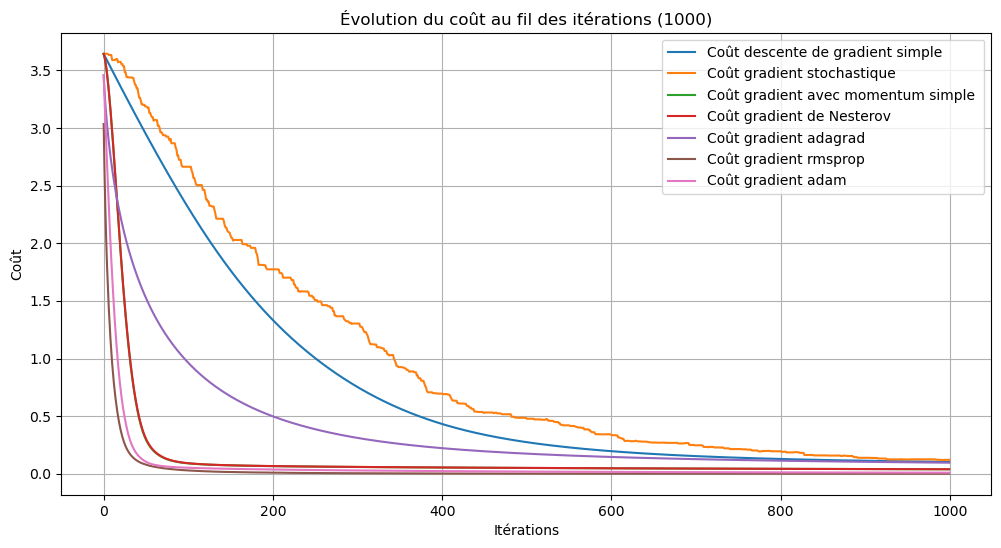

In [24]:

plt.figure(figsize=(12, 6))
# Courbes des coûts

plt.plot(costs_gd, label='Coût descente de gradient simple')
plt.plot(costs_sgd, label='Coût gradient stochastique')
plt.plot(costs_gdm, label='Coût gradient avec momentum simple ')
plt.plot(costs_gdn, label='Coût gradient de Nesterov')
plt.plot(costs_adagrad, label='Coût gradient adagrad')
plt.plot(costs_rmsprop, label='Coût gradient rmsprop')
plt.plot(costs_adam, label='Coût gradient adam')

# Légendes
plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Évolution du coût au fil des itérations (1000)')
plt.legend()
plt.grid(True)
plt.show()

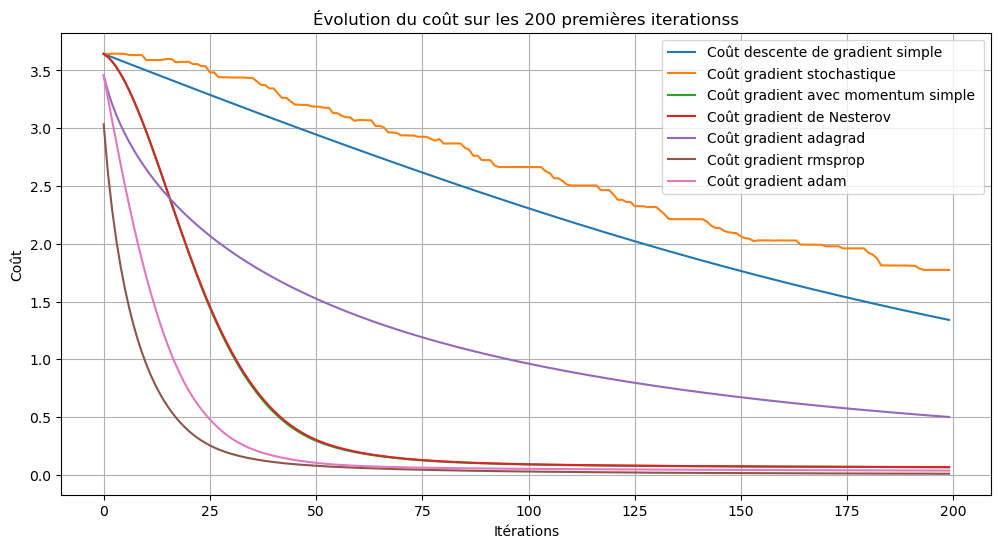

In [25]:
plt.figure(figsize=(12, 6))
# Courbes des coûts

plt.plot(costs_gd[:200], label='Coût descente de gradient simple')
plt.plot(costs_sgd[:200], label='Coût gradient stochastique')
plt.plot(costs_gdm[:200], label='Coût gradient avec momentum simple ')
plt.plot(costs_gdn[:200], label='Coût gradient de Nesterov')
plt.plot(costs_adagrad[:200], label='Coût gradient adagrad')
plt.plot(costs_rmsprop[:200], label='Coût gradient rmsprop')
plt.plot(costs_adam[:200], label='Coût gradient adam')

# Légendes
plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.title('Évolution du coût sur les 200 premières iterationss')
plt.legend()
plt.grid(True)
plt.show()

#### Analyse globale

- Les méthodes adaptatives (RMSprop, Adam) et celles basées sur le momentum (Momentum simple, Nesterov) montrent les meilleures performances en termes de vitesse de convergence et de coût final atteint.

- La descente de gradient stochastique pure (batch_size=1) montre ses limites en termes de stabilité et de vitesse de convergence pour ce problème.
Néanmoins elle réalise presque la même performance que la descente de gradient simple en 1000 mises à jour des poids, et ce en ayant calculé l'erreur sur une seule observation du dataset de training à chaque fois. Elle réalise dans ce cas le même résultat que la gradient descent pour un coût computatoire bien moindre et ayant revu 999 fois moins les données.

- AdaGrad montre une bonne performance initiale mais ralentit significativement, ce qui est un comportement typique de cette méthode sur de longues périodes d'entraînement.

- Le choix du learning_rate (0.05) semble approprié pour la plupart de ces méthodes sur ce dataset, permettant une convergence sans divergence.

#### Validité des coefficients obtenus et comparaison de l'accuracy de chaque méthode 

Nos algorithmes ont bien convergé, mais nous ont ils donné le bon résultat ? C'est à dire les bons coefficients permettant de prédire l'étiquette des données d'entrée. Vérifions cela en prédisant nos étiquettes avec les poids obtenus par chaque méthode. Notre considération ici est juste de savoir si la convergence se fait vers les bonnes cordonnées du coup on utilisera les données d'entrainement par simplification et gain de temps.


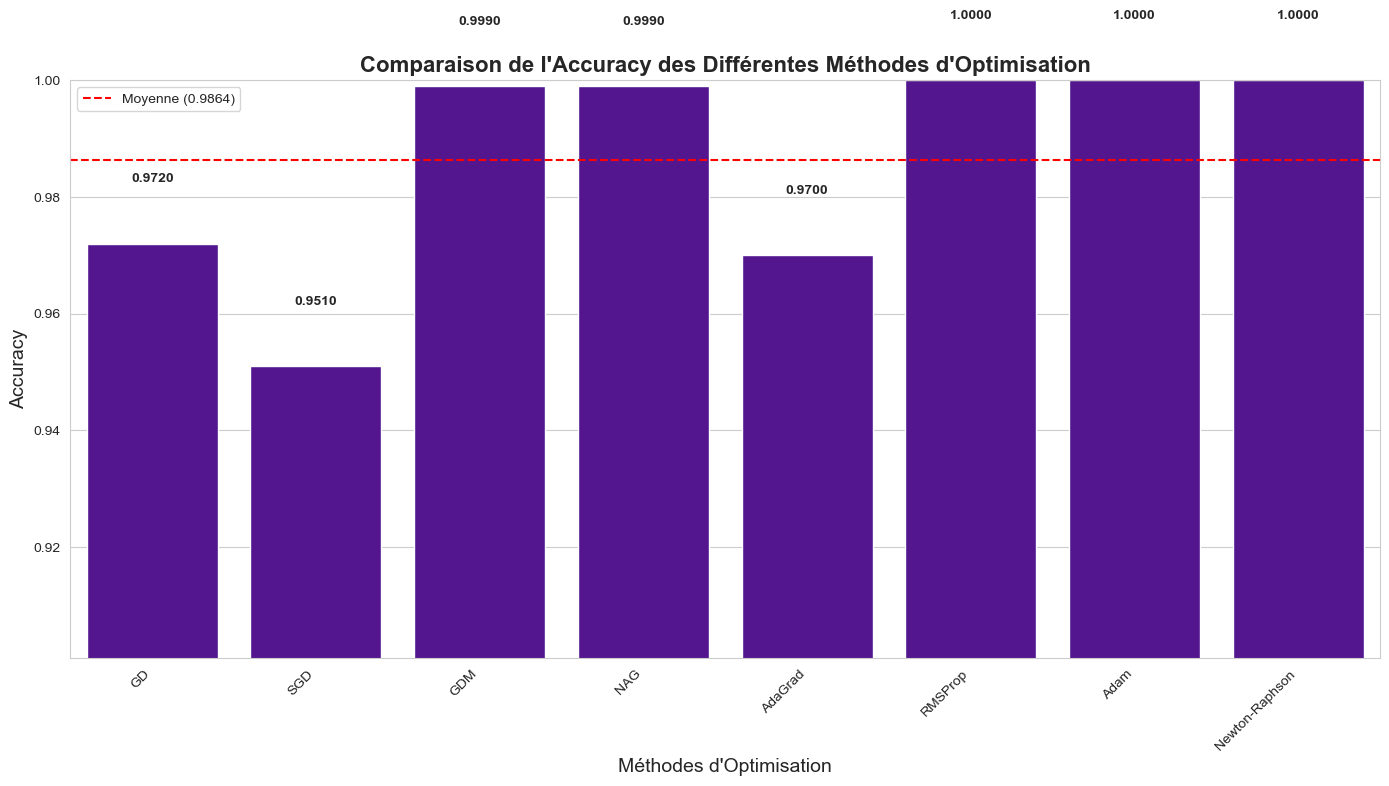

Accuracy des différentes méthodes :
GD: 0.9720
SGD: 0.9510
GDM: 0.9990
NAG: 0.9990
AdaGrad: 0.9700
RMSProp: 1.0000
Adam: 1.0000
Newton-Raphson: 1.0000


In [28]:
# Retrouvons et affichons l'accuracy de chaque méthode, y compris la méthode quasi analytique de Newton-Raphson

# Fonction pour étiqueter à partir de probabilités
def binary_classification(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

# Générer les prédictions pour chaque méthode
y_pred_gd      = predict(X, w_gd)
y_pred_sgd     = predict(X, w_sgd)
y_pred_gdm     = predict(X, w_gdm)
y_pred_gdn     = predict(X, w_gdn)
y_pred_adagrad = predict(X, w_adagrad)
y_pred_rmsprop = predict(X, w_rmsprop)
y_pred_adam    = predict(X, w_adam)
y_pred_newton  = predict(X, beta)

# Transformer les prédictions en classes binaires 
y_pred_gd_binary      = binary_classification(y_pred_gd)
y_pred_sgd_binary     = binary_classification(y_pred_sgd)
y_pred_gdm_binary     = binary_classification(y_pred_gdm)
y_pred_gdn_binary     = binary_classification(y_pred_gdn)
y_pred_adagrad_binary = binary_classification(y_pred_adagrad)
y_pred_rmsprop_binary = binary_classification(y_pred_rmsprop)
y_pred_adam_binary    = binary_classification(y_pred_adam)
y_pred_newton_binary  = binary_classification(y_pred_newton)

# Scores d'accuracy de chaque méthode
from sklearn.metrics import accuracy_score

accuracy_gd      = accuracy_score(y, y_pred_gd_binary)
accuracy_sgd     = accuracy_score(y, y_pred_sgd_binary)
accuracy_gdm     = accuracy_score(y, y_pred_gdm_binary)
accuracy_gdn     = accuracy_score(y, y_pred_gdn_binary)
accuracy_adagrad = accuracy_score(y, y_pred_adagrad_binary)
accuracy_rmsprop = accuracy_score(y, y_pred_rmsprop_binary)
accuracy_adam    = accuracy_score(y, y_pred_adam_binary)
accuracy_newton  = accuracy_score(y, y_pred_newton_binary)

# Liste des méthodes et accuracies
methods = ['GD', 'SGD', 'GDM', 'NAG', 'AdaGrad', 'RMSProp', 'Adam', 'Newton-Raphson']
accuracies = [accuracy_gd, accuracy_sgd, accuracy_gdm, accuracy_gdn, accuracy_adagrad, accuracy_rmsprop, accuracy_adam, accuracy_newton]

# Création d'un DataFrame
df = pd.DataFrame({'Méthode': methods, 'Accuracy': accuracies})

# Configuration du style de seaborn
sns.set_style("whitegrid")
sns.set_palette("plasma")

# Graphique
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Méthode', y='Accuracy', data=df)
for i, v in enumerate(df['Accuracy']):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
plt.title('Comparaison de l\'Accuracy des Différentes Méthodes d\'Optimisation', fontsize=16, fontweight='bold')
plt.xlabel('Méthodes d\'Optimisation', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
y_min = max(0, min(accuracies) - 0.05)
y_max = min(1, max(accuracies) + 0.05)
plt.ylim(y_min, y_max)
plt.xticks(rotation=45, ha='right')
mean_accuracy = df['Accuracy'].mean()
plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f'Moyenne ({mean_accuracy:.4f})')
plt.legend()
plt.tight_layout()
plt.show()

# Affichage des résultats dans la console
print("Accuracy des différentes méthodes :")
for method, accuracy in zip(methods, accuracies):
    print(f"{method}: {accuracy:.4f}")





  
Toutes les méthodes testées montrent d'excellentes performances sur ce dataset simple avec mille itérations. Donc nos algorithmes implémentés font bien le travail qui leur est demandé. Le choix de la méthode optimale dépendra d'autres critères tels que la vitesse de convergence, la stabilité de l'entraînement, et les ressources computationnelles disponibles.

### **2- Effet du pas d'apprentissage sur la convergence**

Dans cette partie, nous allons garder les deux méthodes standards, descente de gradient simple et descente de gradient stochastique. L'idée est d'obtenir l'évolution de la fonction coût avec un pas d'apprentissage dans un intervalle allant de très petit à grand. Le deux graphes qui suivent tracent pour chaque méthode, la courbe d'évolution du coût avec chaque longueur de pas.

In [31]:
# Définir la plage de valeurs de pas d'apprentissage à tester
learning_rates = [ 0.001, 0.01, 0.05, 0.1, 0.5, 1]

# Nombre d'itérations
num_iterations = 1000
batch_size = 1  # SGD pur

# Fonction pour tester différents pas d'apprentissage sur la descente de gradient simple et stochastique
def test_learning_rates(X, y, w_init, learning_rates, num_iterations):
    results_gd = {}
    results_sgd = {}
    
    for lr in learning_rates:
        # Descente de gradient simple
        w_gd, costs_gd = gradient_descent(X, y, w_init, lr, num_iterations)
        results_gd[lr] = costs_gd
        # Descente de gradient stochastique
        w_sgd, costs_sgd = stochastic_gradient_descent(X, y, w_init, lr, 1, batch_size)
        results_sgd[lr] = costs_sgd
    return results_gd, results_sgd

# Lancer les tests
results_gd, results_sgd = test_learning_rates(X, y, w, learning_rates, num_iterations)


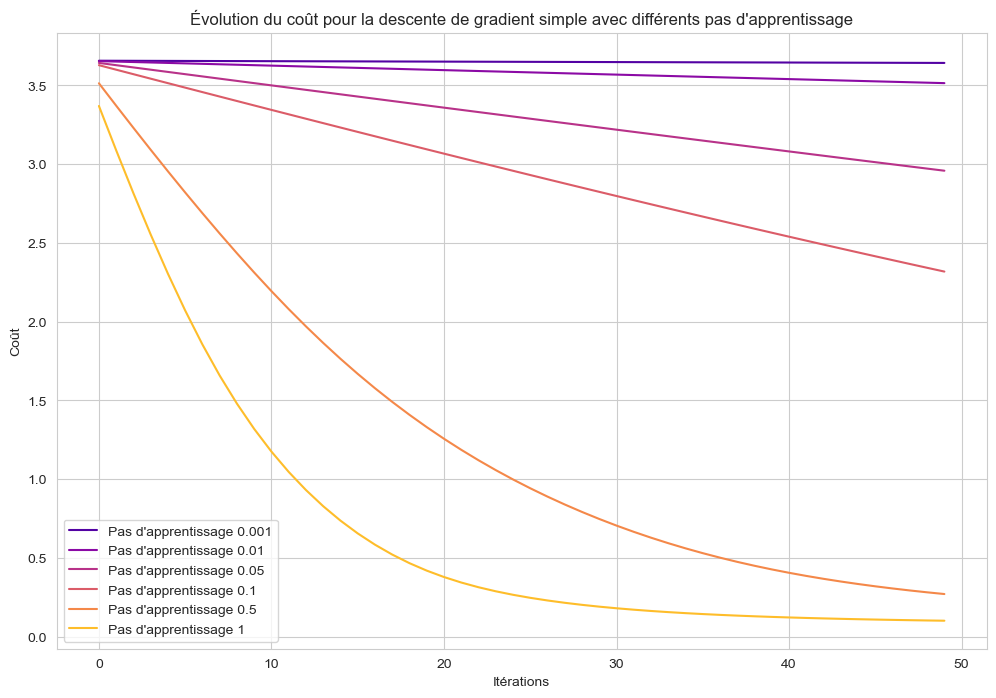

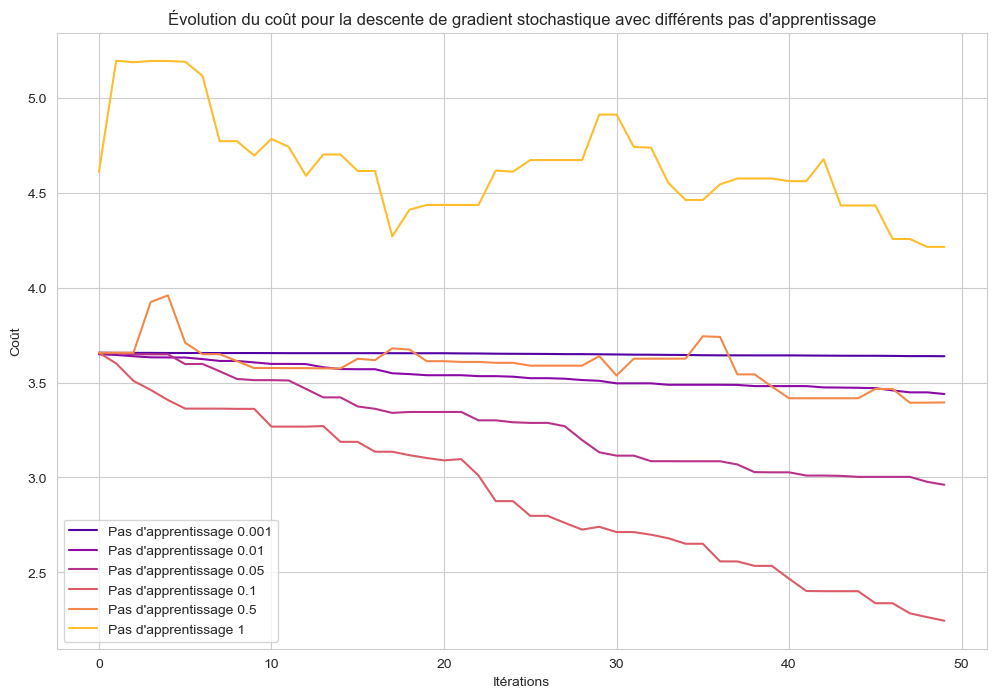

In [32]:
# Visualiser les résultats
def plot_results(results, method_name):
    plt.figure(figsize=(12, 8))
    for lr, costs in results.items():
        plt.plot(costs[:50], label=f"Pas d'apprentissage {lr}")
    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.title(f"Évolution du coût pour la {method_name} avec différents pas d'apprentissage")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualiser les résultats pour la descente de gradient simple
plot_results(results_gd, "descente de gradient simple")

# Visualiser les résultats pour la descente de gradient stochastique
plot_results(results_sgd, "descente de gradient stochastique")

#### Commentaire:

Les deux graphes ci-dessus, montrent clairement une influence forte de l'hypermparamètre "Pas d'apprentissage" sur la vitesse de convergence et sa stabilité. En effet, avec les mêmes données et la même fonction de perte, une changement de l'amplitude du pas, peut empêcher la fonction de converger ou trop la ralentir. Il peut également produire un comportement erratique d'instabilité, qui se manifeste par des changements abruptes et fréquents du sens de déplacement sur la courbe du coût, au fil des itérations.

Afin de mieux saisir les nuances cet effet, essayons de visualiser l'évolution de l'erreur en fonction de l'accroissement du pas d'apprentissage à divers stades de l'apprentissage: 


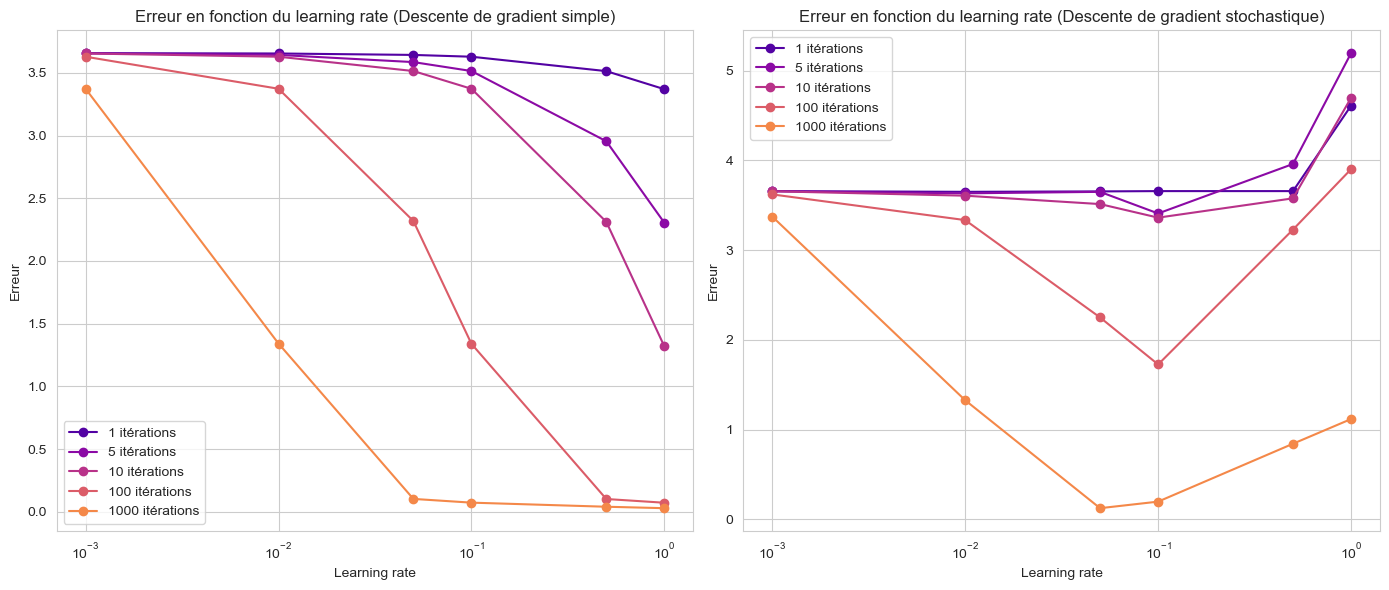

In [34]:
# Numéros d'itérations spécifiques à tracer
iteration_points = [1, 5, 10, 100, 1000]

# Fonction pour tracer les courbes d'erreurs en fonction du learning_rate
def plot_learning_rate_vs_errors(ax, results, method_name):
    # Pour chaque point d'itération, on trace la courbe correspondante
    for num_iter in iteration_points:
        errors = [results[lr][num_iter - 1] if num_iter <= len(results[lr]) else None for lr in learning_rates]
        ax.plot(learning_rates, errors, marker='o', label=f'{num_iter} itérations')

    ax.set_title(f'Erreur en fonction du learning rate ({method_name})')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Erreur')
    ax.set_xscale('log')  # Échelle logarithmique pour mieux visualiser les différences
    ax.legend()
    ax.grid(True)

# Créer une figure avec deux sous-graphiques côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 ligne, 2 colonnes
plot_learning_rate_vs_errors(ax1, results_gd, 'Descente de gradient simple')
plot_learning_rate_vs_errors(ax2, results_sgd, 'Descente de gradient stochastique')
plt.tight_layout()
plt.show()

Nous pouvons distinguer trois cas de figures dans l'ensemble:

#### **a- Un pas d'apprentissage sous-évalué (trop faible)**

Dans les graphiques, le pas d'apprentissage 0.001 peut être considéré comme trop faible pour les deux méthodes (GD et SGD):

- La convergence est lente voire imperceptible : Pour 1000 itérations, l'erreur reste très élevée et autour de l'erreur initiale, alors que d'autres learning rates ont permis de converger déjà.
  
- La SGD perd son avantage, sa nature stochastique ne procure plus d'avantage significatif avec un pas aussi petit.

Avec un pas aussi petit, nous avons des implications pratique de non efficacité: 

- Temps de calcul excessif : Un pas trop petit nécessite un nombre d'itérations beaucoup plus important pour atteindre la convergence.

- Risque de stagnation : L'algorithme peut rester bloqué dans des plateaux ou des régions à faible gradient de la surface de la fonction coût.

#### **b- Un pas d'apprentissage sur-évalué (trop élevé)**

Dans notre expérience, Les manifestations d'un pas trop élevé sont perceptibles au niveau de l'évolution du coût de la descente stochastique (SGD), ce qui était prévisible. 

Nous observons par contre que la descente de gradient simple se montre particulièrement robuste, et tire même profit d'une augmentation exagérée du pas d'apprentissage. Cela s'explique par des proprietés intrinsèques et par la nature des données sur lesquelles on travaille:

- Fonction de coût convexe et lisse : la log-vraisemblance négative est convexe et lisse. Cela signifie qu'elle n'a qu'un minimum global et pas de minima locaux, et qu'elle a un gradient bien défini qui ne change pas brutalement. Ces deux proprietés offrent des garanties sur la convergence vers un minimum global et sur la stabilité dans la descente.
  
  ( pour le plaisir, démonstration de la convexité et de la lissité de la log-vraisemblance négative en "Annexe-1")

- Data issue d'une distribution normale de moyenne 0 et de variance 1 : Cela impacte la pente de la fonction perte en la maintenant à des valeurs modérées, et permettant ainsi une plus grande tolérance à un pas d'apprentissage élevé.
  
  Dans la théorie de l'optimisation convexe, pour garantir une convergence stable vers un minimum global, Le pas d'apprentissage doit être inférieur à $\frac{1}{L}$. $L$ étant La constante de **Lipschitz** qui peut être estimée par la norme spectrale maximale de la Hessienne, c'est-à-dire la plus grande valeur propre de la matrice $H(\theta)$. Dans le cas de la régression logistique, cela donne une estimation de $L$ sous la forme :
$$
L \approx \frac{1}{4} \max_i ||x_i||^2
$$

  Avec nos données issues d'une $N(0, 1)$, $||x_i|| \approx 1$ ce qui est modéré, et notre constante $L \approx \frac{1}{4}$ reste elle même modérée. Ainsi l'algorithme peut se permettre des valeurs de pas d'apprentissage plus élevées.

  - Autorégulation entre pas d'apprentissage et gradient : en s'approchant du minimum global, la pente s'amoindrit de plus en plus. Le produit du pas d'apprentissage par le gradient reste ainsi dans des marges acceptables et la mise à jour des poids ne fait pas de sauts erratiques.

 
    

<br>
C'est au niveau de la descente de gradient stochastique(SGD) que l'ont peut bien distinguer les anomalies induites par un choix de pas d'apprentissage non adapté et exagérément haut. En effet pour les pas de 0.5 et 1 on remarque que l'erreur commence par augmenter, c'est à dire que les mises à jour ne se font pas dans le bon sens. On remarque également qu'à l'instar des tous petits pas, il n'y a pas eu convergence de l'algorithme au bout des milles itérations, avec 0.5 et 1 comme pas d'apprentissage. Nous soulignons égalmement une instabilité qui se manifeste par des oscillations importantes, c'est dire que la recherche du chemin vers le minimum global se fait de façon erratique et avec des sauts pouvant en éloigner.


- La vitesse de la convergence : la SGD n'a pas pu profiter d'un gain en début d'entrainement grâce à un grand pas, au contraire elle a été éloignée du minimum global. Ensuite, elle a continué à en patir, sous forme d'une convergence très lente et non garantie, car il est parfaitement possible que l'algorithme diverge avec plus d'itérations. Un pas d'apprentissage trop grand ralentit la vitesse de convergence voire cause la divergence.

- Stabilité : Cela se manifeste par des oscillations significatives autour de la direction optimale de descente. Au lieu d'effectuer des mises à jour progressives et cohérentes vers le minimum global, l'algorithme saute d'une région à l'autre de manière erratique, ce qui rend la convergence incertaine. Ces oscillations peuvent entraîner un comportement chaotique de l'algorithme, où les itérations suivantes peuvent annuler en partie les progrès faits précédemment. Ce manque de stabilité complique la trajectoire vers le minimum global, car il est difficile pour l'algorithme de "se fixer" sur une bonne direction, le faisant osciller en permanence et potentiellement diverger avec davantage d'itérations.
  Une façon de quantifier cette instabilité est d'estimer la variance de l'erreur pour chaque pas d'apprentissage :






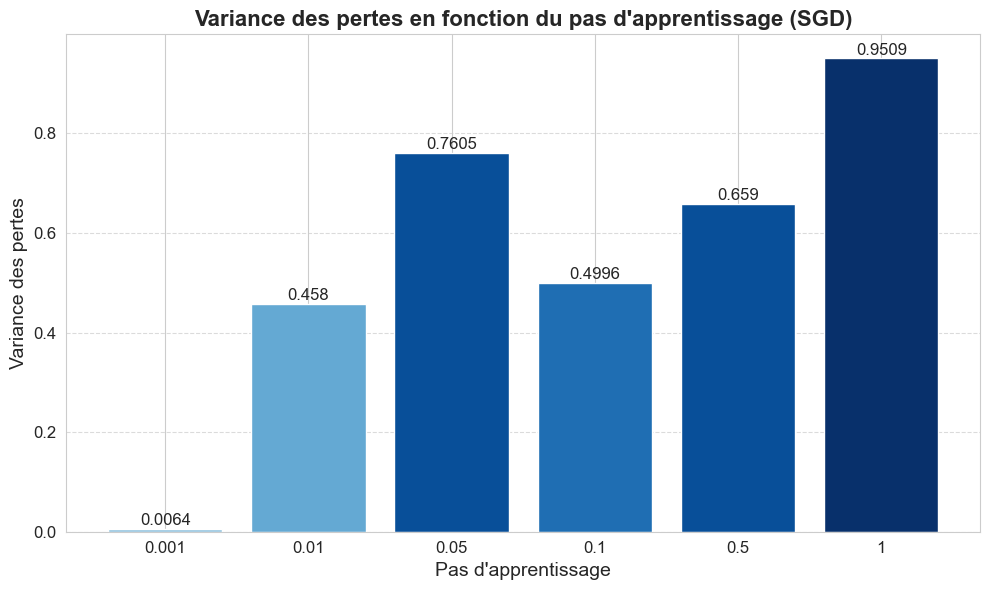

In [37]:
# Estimation de l'instabilité par la variance des pertes

# Calculer la variance des pertes pour chaque pas d'apprentissage
variances_sgd = {lr: np.var(costs) for lr, costs in results_sgd.items()}

# Extraire les valeurs des learning rates et les variances pour le plot
learning_rates = list(variances_sgd.keys())
variances = list(variances_sgd.values())

colors = plt.cm.Blues(np.linspace(0.4, 1, len(learning_rates)))
colors[2], colors[4] = colors[4], colors[2]

plt.figure(figsize=(10, 6))
bars = plt.bar([str(lr) for lr in learning_rates], variances, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom', fontsize=12)

plt.style.use('ggplot')
plt.title('Variance des pertes en fonction du pas d\'apprentissage (SGD)', fontsize=16, fontweight='bold')
plt.xlabel('Pas d\'apprentissage', fontsize=14)
plt.ylabel('Variance des pertes', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

    Comme on pouvait s'y attendre, le plus grand pas d'apprentissage a la plus grande variance des valeurs de la perte au fil des itérations. A contrario le plus petit pas est celui qui a la plus petite variance. Cela donne une idée globale, mais une mesure plus révélatrice serait d'estimer la variance des écarts entre pertes successives au fil des itérations, tel que le montre ce graphe:

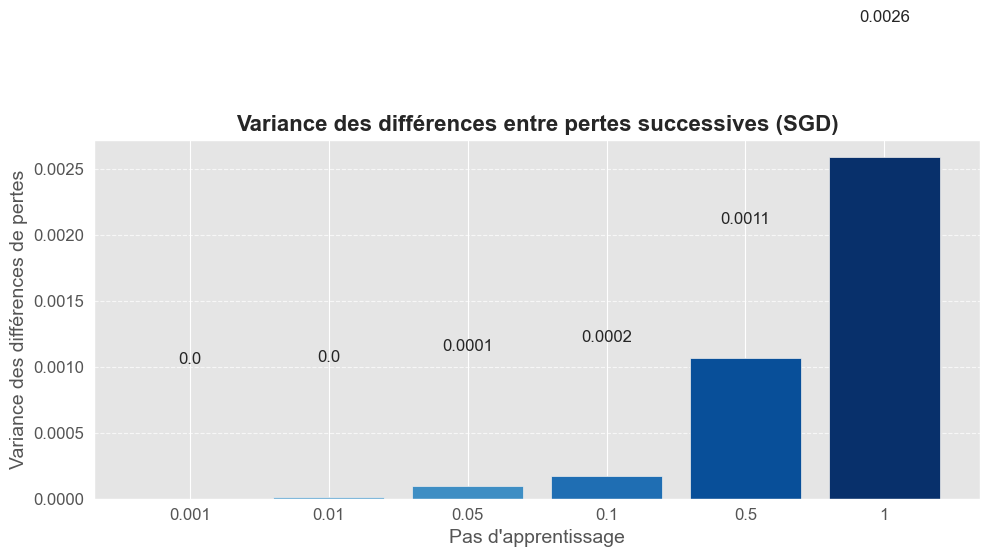

In [39]:
# Calculer la variance des différences entre pertes successives pour chaque pas d'apprentissage
variance_differences_sgd = {lr: np.var(np.diff(costs)) for lr, costs in results_sgd.items()}

# Extraire les valeurs des learning rates et les variances pour le plot
learning_rates = list(variance_differences_sgd.keys())
variance_differences = list(variance_differences_sgd.values())

# Tracer un graphique des variances des différences entre pertes successives
plt.figure(figsize=(10, 6))
bars = plt.bar([str(lr) for lr in learning_rates], variance_differences, color=plt.cm.Blues(np.linspace(0.4, 1, len(learning_rates))))
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom', fontsize=12)
plt.title('Variance des différences entre pertes successives (SGD)', fontsize=16, fontweight='bold')
plt.xlabel('Pas d\'apprentissage', fontsize=14)
plt.ylabel('Variance des différences de pertes', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


    Avec cette variance, nous pouvons visualiser que les pas de 0.5 et 1 ont les plus grandes variations de valeur de perte d'une itération à une autre et ce malgré un résultat bien loin de l'optimum. Cela s'explique par le comportement instable ou une oscillation peut annuler partiellement ou totalement un gain précédent de descente vers l'optimum.

#### **c- Le pas d'apprentissage adapté**

- La descente de gradient simple: D'après la théorie présentée précédemment et applicable dans le cas d'une fonction de perte convexe et lisse, nous pouvions avoir la garantie d'une convergence stable avec un pas d'apprentissage allant jusqu'à **$\frac{1}{L}$**, avec $L$ constante de Lipschitz.

  Or avec des données issues d'une distrubtion $N$(0,1) , la valeur de $L$ est appriximée par **$\frac{1}{4}$**.

  Nous pouvons ainsi, théoriquement nous permettre un pas d'apprentissage allant jusqu'à **4**, en étant assurée d'une convergence stable.

  Essayons:

In [42]:
w_gd_guarantedOptimals,costs_gd_guarantedConvergence_lr = gradient_descent(X, y, w, 4, 1000)

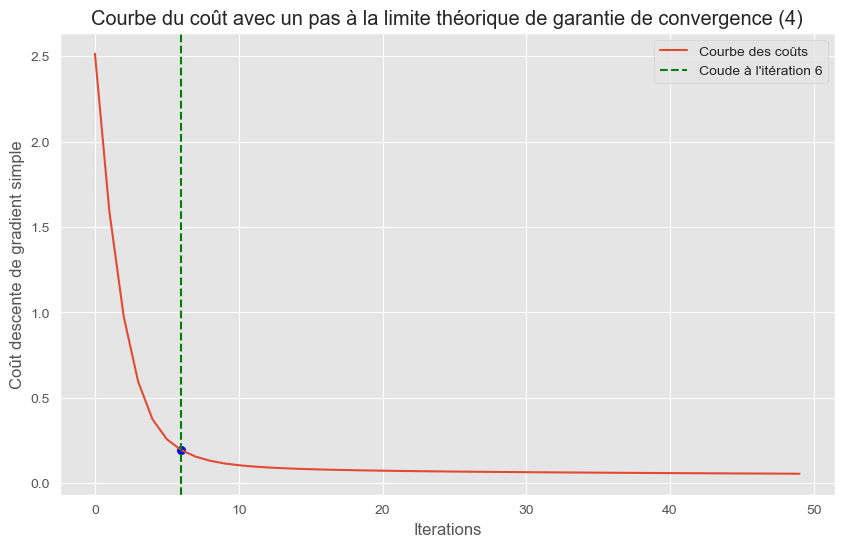

Le coude a été détecté à l'itération : 6


In [43]:
# Essayons de localiser le critère du coude sur le coût
from kneed import KneeLocator


costs = costs_gd_guarantedConvergence_lr[:50]  # Remplacez par vos données
iterations = range(len(costs))

# Utilisation de KneeLocator pour détecter le coude
kneedle = KneeLocator(iterations, costs, curve='convex', direction='decreasing')
elbow_index = kneedle.elbow

# Plotter la courbe des coûts avec le coude
plt.figure(figsize=(10, 6))
plt.plot(iterations, costs, label='Courbe des coûts')
plt.axvline(x=elbow_index, color='g', linestyle='--', label=f'Coude à l\'itération {elbow_index}')
plt.scatter(elbow_index, costs[elbow_index], color='b')  # Marquer le point du coude
plt.title('Courbe du coût avec un pas à la limite théorique de garantie de convergence (4)')
plt.xlabel('Iterations')
plt.ylabel('Coût descente de gradient simple')
plt.legend()
plt.show()

print(f"Le coude a été détecté à l'itération : {elbow_index}")


Ainsi avec le pas d'apprentissage de 4, la courbe de perte a bel et bien gagné en vitesse de convergence. En plus, elle montre un maximum de gain dans l'amélioration du coût à partir de l'itération 6, ce qui est remarquablement efficace. Ce resultat confirme l'heuristique théorique présentée précédemment.



- **Descente de gradient stochastique**: En reprenant le graphique de l'évolution du coût en fonction du pas d'apprentissage et ce à divers stades de l'entrainement, nous nous rendons compte que les grandes valeurs de pas d'apprentissage montrent toutes une tendance haussière du coût. Les petites valeurs de pas montrent toutes une stagnation ou une faible évolution de la perte. Ce qui nous interresse c'est la forme en cuve que prennent au fil de l'augmentation du pas les courbes de coût autour des valeurs 0.05 et 0.1 :

  Toutes les courbes atteignent un minimum entre ces deux valeurs de pas. Autrement dit, le pas d'apprentissage efficace, sur ce problème et avec ces données, pour réduire le coût, est situe entre **0.05** et **0.1**
  

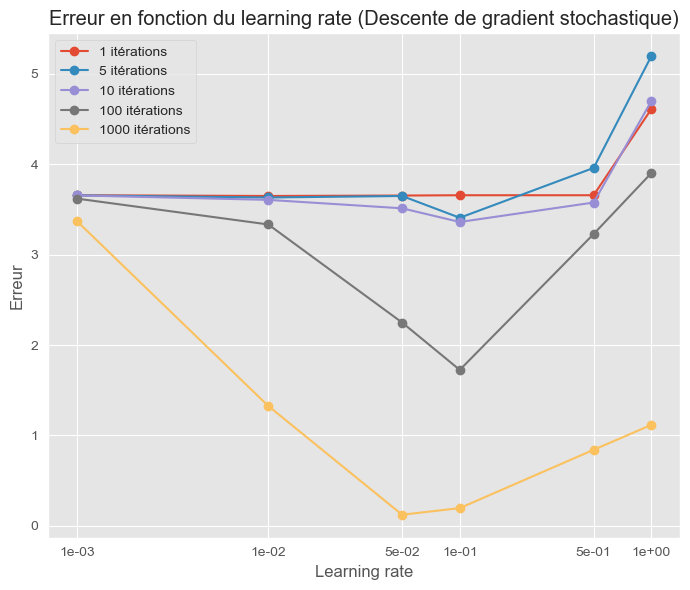

In [46]:
# Numéros d'itérations spécifiques à tracer
iteration_points = [1, 5, 10, 100, 1000]

# Fonction pour tracer les courbes d'erreurs en fonction du learning_rate
def plot_learning_rate_vs_errors(ax, results, method_name):
    # Pour chaque point d'itération, on trace la courbe correspondante
    for num_iter in iteration_points:
        errors = [results[lr][num_iter - 1] if num_iter <= len(results[lr]) else None for lr in learning_rates]
        ax.plot(learning_rates, errors, marker='o', label=f'{num_iter} itérations')

    ax.set_title(f'Erreur en fonction du learning rate ({method_name})')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Erreur')
    ax.set_xscale('log')  # Notons bien l'écchelle logarithmique ici pour lisser les distances entre pas 
    ax.set_xticks(learning_rates)  # Pour afficher les valeurs du learning rate sur les abscisses
    ax.set_xticklabels([f'{lr:.0e}' for lr in learning_rates])  # Formatage des labels en notation scientifique si nécessaire
    ax.legend()
    ax.grid(True)

# Créer une figure avec un seul graphique pour la descente de gradient stochastique
fig, ax = plt.subplots(figsize=(7, 6))  # Taille ajustée pour un seul graphique
plot_learning_rate_vs_errors(ax, results_sgd, 'Descente de gradient stochastique')
plt.tight_layout()
plt.show()


## **III- L'hyperparamètre "Batch-size" et la convergence du gradient stochastique**

Le Batch size est le nombre d'exemples que l'algorithme prend en compte pour évaluer sa prochaine mise à jour des poids. Autrement dit, de la quantité de données à prendre en compte avant de décider de la direction du prochain pas de recherche du point le optimal de la fonction de coût. 

Dans la phase de tests initiaux, nous avons vu que la descente de gradient stochastique pure, sur cette fonction de perte convexe et lisse, réalisait à nombre de mises à jours égales (1000 déplacements) et en prenant une observation à la fois, quasiment la même performance qu'une descente de gradient simple qui aura revu le training-set 999 fois supplémentaires. Cela était un argument fort pour se pencher sur ce paramètre et essayer d'évaluer son rôle dans la descente de gradient d'un point de vue de l'optimisation.

Dans un premier temps, intérressons nous à mener l'expérience de tester diverses valeurs de batch-size et d'observer l'effet de changement de la taille de batch sur la courbe de perte à nombre de mises à jours égales.

Le pas d'apprentissage de 0.1 sera adopté d'après nos observations de la section précédente.

Dans cette expérience, et vue l'implémentation de la fonction gradient stochastique, le paramètre batch_size sera égal au paramètre epoch, cette égalité permettera un nombre d'itérations constant pour toutes les valeurs de batch-size essayées.

en effet :

$$\text{Nombre d'itérations} = \frac{N}{\text{batch\_size}} \times \text{epochs}$$

Nous adopterons des valeurs de batch-size appartenant aux diviseurs de la taille du dataset $\left\{1,2,4, ...,250,\frac{N}{2}\right\}$, pour ne pas prendre le risque d'avoir un dernier batch traité qui soit d'une taille inférieure.

In [48]:
# Paramètres de l'expérience "descente de gradient stochastique avec différents batchs-size"

learning_rate = 0.1
w_initial = w.copy()  # toujours faire une copie pour garderla matrice d'initialisation intacte
batch_sizes = [1,2,4,8,20,40,100,200,250,500]  # Différentes valeurs de batch_size dans les diviseurs de N

results = {}

# Boucle de calcul des coûts pour chaque taille de batch
for batch_size in batch_sizes:
    num_epochs = batch_size # dans ce cas, ca conserve bien le même nombre d'itérations
    print(f"\n\nExécution pour num_epochs = {num_epochs}, batch_size = {batch_size}")
    
    w_opt, costs = stochastic_gradient_descent(X, y, w_initial, learning_rate, num_epochs, batch_size)
    
    # Stockage des résultats pour cette combinaison
    results[batch_size] = {
        "weights": w_opt,
        "costs": costs
    }
    print(f"Coût final : {costs[-1]}")




Exécution pour num_epochs = 1, batch_size = 1
Coût final : 0.21925277469475582


Exécution pour num_epochs = 2, batch_size = 2
Coût final : 0.08071999030512404


Exécution pour num_epochs = 4, batch_size = 4
Coût final : 0.06843070177102255


Exécution pour num_epochs = 8, batch_size = 8
Coût final : 0.07074087787176944


Exécution pour num_epochs = 20, batch_size = 20
Coût final : 0.07202625189153827


Exécution pour num_epochs = 40, batch_size = 40
Coût final : 0.07252209524779579


Exécution pour num_epochs = 100, batch_size = 100
Coût final : 0.07293756721726821


Exécution pour num_epochs = 200, batch_size = 200
Coût final : 0.07303334169902052


Exécution pour num_epochs = 250, batch_size = 250
Coût final : 0.07305298370127133


Exécution pour num_epochs = 500, batch_size = 500
Coût final : 0.07309502474197808


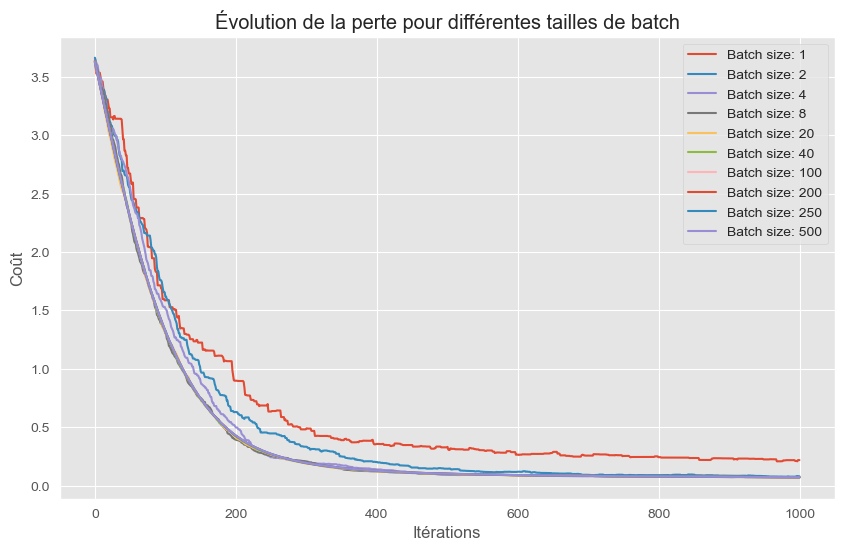

In [49]:
# Maintenant, traçons les courbes de perte
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    costs = results[batch_size]["costs"][:1000]
    plt.plot(costs, label=f'Batch size: {batch_size}')
plt.title("Évolution de la perte pour différentes tailles de batch")
plt.xlabel("Itérations")
plt.ylabel("Coût")
plt.legend()
plt.show()


Nos descentes ont bel et bien convergé pour les différentes valeurs de batch.

Néanmoins nous remarquons une différenciation en deux groupe:

- Pour un batch size de 1 et 2, la vitesse de convergence est moins rapide et la descente instable, en particulier pour la descente de gradient pure qui de surcroit converge vers un optimum significativement plus élevé que les autres.
  
- A partir d'une taille de batch de 4 (soit 0.4 % de la taille du dataset), une stabilité d'installe avec une vitesse de convergence qui semble proche voir équivalente.

Essayons de visualiser les itérations auxquelles 90 % de la perte a été réduite. Plottons les en fonction de la taille de batch:

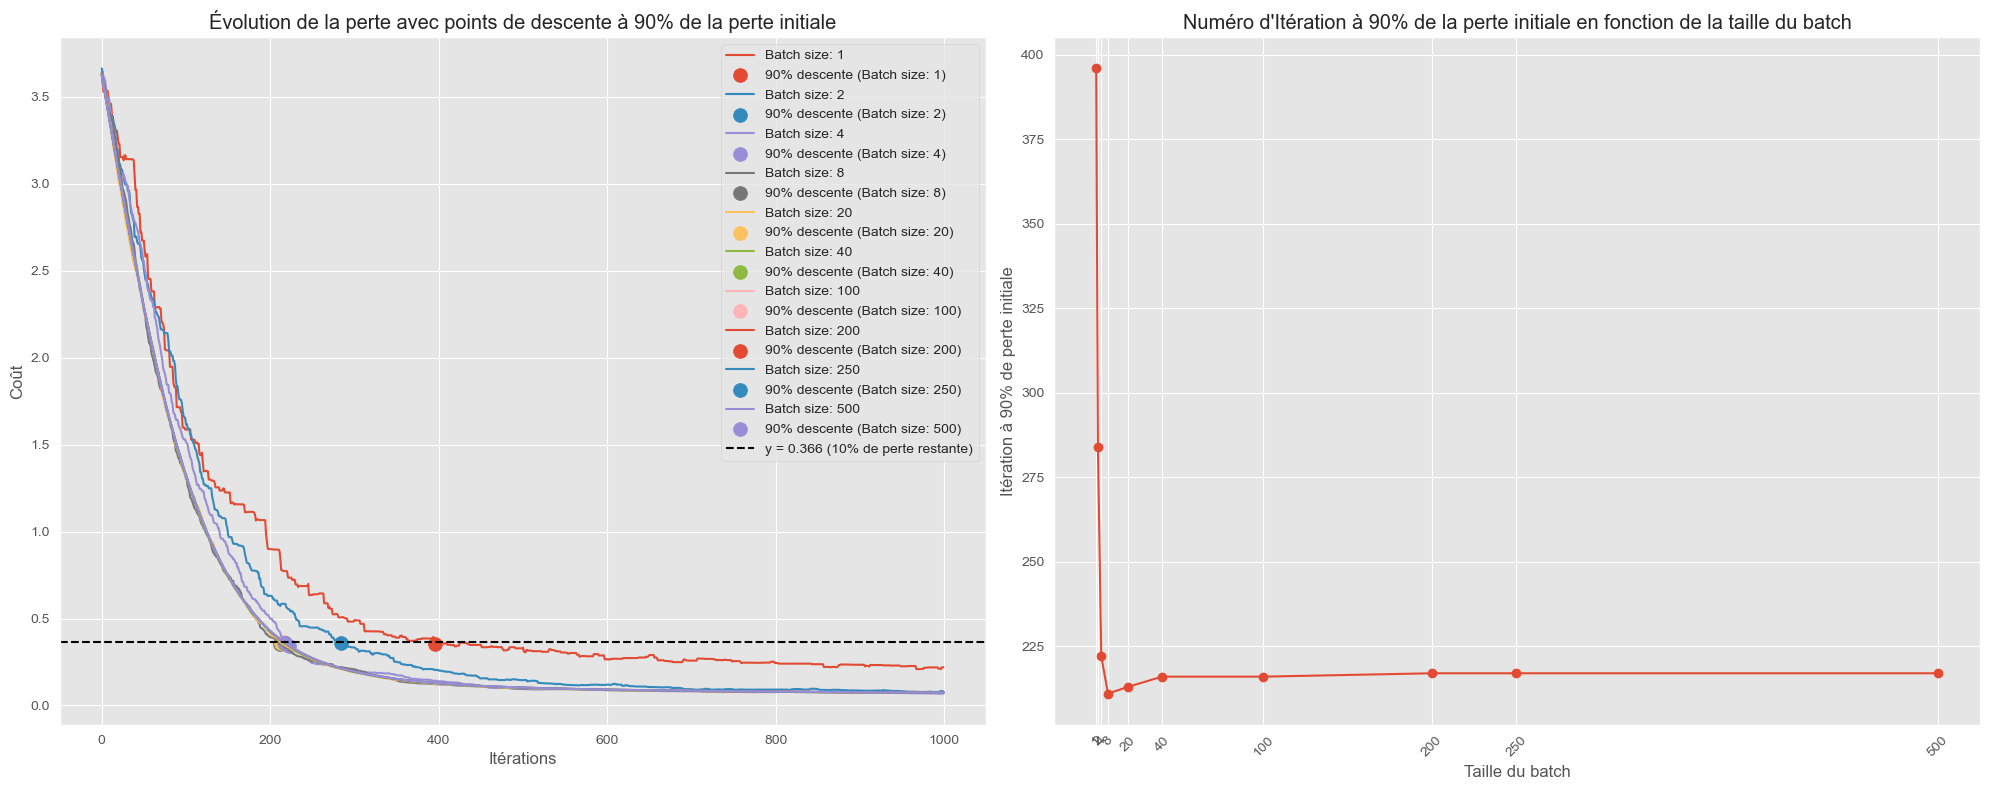

Batch size: 1, 90% de réduction de l'erreur à l'itération 396
Batch size: 2, 90% de réduction de l'erreur à l'itération 284
Batch size: 4, 90% de réduction de l'erreur à l'itération 222
Batch size: 8, 90% de réduction de l'erreur à l'itération 211
Batch size: 20, 90% de réduction de l'erreur à l'itération 213
Batch size: 40, 90% de réduction de l'erreur à l'itération 216
Batch size: 100, 90% de réduction de l'erreur à l'itération 216
Batch size: 200, 90% de réduction de l'erreur à l'itération 217
Batch size: 250, 90% de réduction de l'erreur à l'itération 217
Batch size: 500, 90% de réduction de l'erreur à l'itération 217


In [51]:

# Fonction pour calculer où un certain pourcentage de la perte initiale est atteint
def find_percentage_loss_point(costs, percentage):
    initial_loss = costs[0]
    target_loss = initial_loss * ((100 - percentage) / 100)  # Calcul du pourcentage de réduction de la perte
    for i, cost in enumerate(costs):
        if cost <= target_loss:
            return i
    return None  # Si le point n'est pas trouvé

# Choisir un pourcentage pour calculer le point de descente
percentage = 90  

# Calcul des points où le pourcentage de la perte initiale est atteint
loss_percentage_points = {}
for batch_size in batch_sizes:
    costs = results[batch_size]["costs"][:1000]
    # Trouver le point où le pourcentage de la perte initiale est atteint
    point_percentage = find_percentage_loss_point(costs, percentage)
    loss_percentage_points[batch_size] = point_percentage

# Plotter
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Premier graphique : courbes de coût originales avec points où le pourcentage de perte initiale est atteint
for batch_size in batch_sizes:
    # Tracer les vraies valeurs de la courbe (non lissées)
    costs = results[batch_size]["costs"][:1000]
    ax1.plot(costs, label=f'Batch size: {batch_size}')

    # Si le point où le pourcentage de la perte initiale est atteint est trouvé, l'afficher sur la courbe non lissée
    if loss_percentage_points[batch_size] is not None:
        iteration_percentage = loss_percentage_points[batch_size]
        ax1.scatter(iteration_percentage, costs[iteration_percentage], marker='o', s=100, 
                    label=f'{percentage}% descente (Batch size: {batch_size})')
        


ax1.set_title(f"Évolution de la perte avec points de descente à {percentage}% de la perte initiale")
ax1.axhline(y=0.366, color='black', linestyle='--', label='y = 0.366 (10% de perte restante)')
ax1.set_xlabel("Itérations")
ax1.set_ylabel("Coût")
ax1.legend()

# Deuxième graphique : points où le pourcentage de la perte est atteint en fonction de la taille du batch
batch_sizes_list = list(batch_sizes)
loss_percentage_iterations = [loss_percentage_points[bs] if loss_percentage_points[bs] is not None else np.nan for bs in batch_sizes_list]

ax2.plot(batch_sizes_list, loss_percentage_iterations, marker='o')
ax2.set_title(f"Numéro d'Itération à {percentage}% de la perte initiale en fonction de la taille du batch")
ax2.set_xlabel("Taille du batch")
ax2.set_ylabel(f"Itération à {percentage}% de perte initiale")
ax2.set_xticks(batch_sizes_list)
ax2.set_xticklabels(batch_sizes_list, rotation=45)
plt.tight_layout()
plt.show()

# Afficher les valeurs numériques des points où le pourcentage de la perte est atteint
for bs, iteration in loss_percentage_points.items():
    if iteration is not None:
        print(f"Batch size: {bs}, {percentage}% de réduction de l'erreur à l'itération {iteration}")
    else:
        print(f"Batch size: {bs}, {percentage}% de réduction non atteinte dans les 1000 premières itérations")


Le graphe ci-dessus montre une décroissance très rapide du nombre d'itérations nécessaires à la réduction de 90% de l'erreur, quand on augmente la taille du batch. Nous passons de 396 itérations nécéssaires avec la stochastique pure (batch-size = 1), à 284 itérations avec deux échantillons pris à la fois, pour ensuite atteindre 211 itérations avec une taille de batch de 8. Le gain en rapidité stagne après.

Visualisons  le classement des tailles de batch par ordre décroissant de rapidité à réduire l'erreur de 90%:

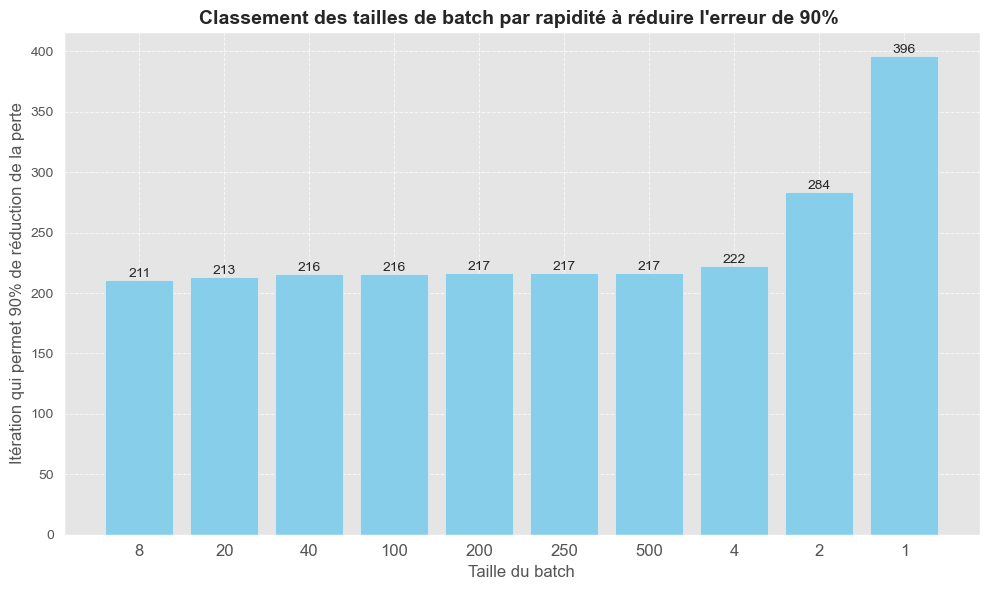

In [53]:


# Trier les tailles de batch en fonction de l'itération où 90 % de la perte est atteinte
sorted_batch_sizes = sorted(loss_percentage_points, key=lambda x: loss_percentage_points[x] if loss_percentage_points[x] is not None else float('inf'))

# Créer un graphique en barre pour visualiser le classement
fig, ax = plt.subplots(figsize=(10, 6))

sorted_iterations = [loss_percentage_points[bs] for bs in sorted_batch_sizes]

# Affichage des barres avec les numéros d'itération
bars = ax.bar(range(len(sorted_batch_sizes)), sorted_iterations, color='skyblue')

# Ajouter les numéros d'itération au-dessus des barres
for bar, iteration in zip(bars, sorted_iterations):
    if iteration is not None:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(iteration)}',
                ha='center', va='bottom', fontsize=10)

# Ajouter des titres et des labels
ax.set_title(f"Classement des tailles de batch par rapidité à réduire l'erreur de {percentage}% ", fontsize=14, fontweight='bold')
ax.set_xlabel("Taille du batch", fontsize=12)
ax.set_ylabel(f"Itération qui permet {percentage}% de réduction de la perte", fontsize=12)
ax.set_xticks(range(len(sorted_batch_sizes)))
ax.set_xticklabels(sorted_batch_sizes, fontsize=12)

# Ajouter une grille pour plus de lisibilité
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


Les valeurs de batch-size ayant donné les descentes les plus lentes (en nombre d'itérations), sont la taille 1 et 2.

En augmentant la taille de batch au delà, la vitesse de réduction de 90 % de l'erreur stagne entre 211 et 217 itérations. Cela suggère que sur cet ensemble de données et avec les différents paramètres pris, il serait non nécéssaire d'aller au delà d'une taille de 4 échantillons pour le batch-size si l'on considère juste la réduction du risque empirique et l'économie computationnelle. Car en effet, rappelons nous qu'à performance quasi égale, la descente avec un batch-size de 500, a eu un besoin de revoir les données 125 fois supérieur à celui de la descente avec un batch size de 4.

Pour avoir une idée de ce coût computationnel qui augmente avec le nombre d'epochs, voici une implémentation naive de la fonction descente de gradient stochastique intégrant un compteur simpliste de d'opérations flottantes "FLOPS", qui s'interresse essentiellement aux opéreations matricielles et qui ignore les optimisations possibles. Quand on applique la descente avec un nombre d'itérations identique mais avec diverses valeurs de batch-size, nous obtenons l'ordre de croissance suivant du coût computationnel en Flops:


In [55]:
# Implémentation naive d'un compteur de FLOPs 
def stochastic_gradient_descent_flops(X, y, w_random, learning_rate, num_epochs, batch_size=1):
    """
    Implémente l'algorithme de descente de gradient stochastique pour la régression logistique avec un 
    compteur de FLOPs.

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    num_epochs : nombre d'époques (passages complets sur les données)
    batch_size : taille des mini-batchs (1 pour SGD pur, >1 pour mini-batch SGD)

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à intervalles réguliers
    total_flops : nombre total de FLOPs effectuées
    """
    m, n = X.shape  # m: nombre total d'échantillons, n: nombre de caractéristiques
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy()  # Pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    
    total_flops = 0  # Compteur de FLOPs

    for epoch in range(num_epochs):
        # Mélange aléatoire des indices des échantillons
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Parcours des mini-batchs
        for i in range(0, m, batch_size):
            # Sélection du mini-batch courant
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # FLOPs pour calculer les prédictions : produit matrice-vecteur
            # Nombre d'opérations pour un produit matrice-vecteur est 2 * batch_size * n
            y_pred = predict(X_batch, w)
            total_flops += 2 * batch_size * n

            # FLOPs pour calculer les gradients : produit matrice-transposée et soustraction
            # Nombre d'opérations pour le gradient : 2 * n * batch_size pour le produit X.T @ (y_pred - y_batch)
            dw = (1 / batch_size) * np.dot(X_batch.T, (y_pred - y_batch))
            total_flops += 2 * batch_size * n

            # FLOPs pour la somme des erreurs : n additions pour la somme des différences
            db = (1 / batch_size) * np.sum(y_pred - y_batch)
            total_flops += batch_size  # On compte une addition par échantillon dans le batch

            # Mise à jour des poids : n multiplications et n additions pour chaque mise à jour de w
            w[1:] -= learning_rate * dw
            total_flops += 2 * n  # n multiplications et n additions
            w[0] -= learning_rate * db
            total_flops += 2  # 1 multiplication et 1 addition pour le biais

            # Calcul et stockage du coût : coût sur tout le batch
            cost = cost_function(X, y, w)
            costs.append(cost)
            #total_flops += batch_size * n  # exclu en démonstration

    return w, costs, total_flops

In [56]:
# Calcul du coût computationnel, à nombre d'itérations égale et batch-size croissant

learning_rate = 0.1
w_initial = w.copy()  
batch_sizes = [1,2,4,8,20,40,100,200,250,500]  # Différentes valeurs de batch_size dans les diviseurs de N

results = {}

# Boucle de calcul des coûts pour chaque taille de batch
for batch_size in batch_sizes:
    num_epochs = batch_size # dans ce cas, ca conserve bien le même nombre d'itérations
    print(f"\n\nExécution pour num_epochs = {num_epochs}, batch_size = {batch_size}")
    
    w_opt, costs, total_flops = stochastic_gradient_descent_flops(X, y, w_initial, learning_rate, num_epochs, batch_size)
    
    # Stockage des résultats pour cette combinaison
    results[batch_size] = {
        "weights": w_opt,
        "costs": costs,
        "total_flops" : total_flops
    }
    print(f" Total Flops  : {total_flops}")
    



Exécution pour num_epochs = 1, batch_size = 1
 Total Flops  : 603000


Exécution pour num_epochs = 2, batch_size = 2
 Total Flops  : 1004000


Exécution pour num_epochs = 4, batch_size = 4
 Total Flops  : 1806000


Exécution pour num_epochs = 8, batch_size = 8
 Total Flops  : 3410000


Exécution pour num_epochs = 20, batch_size = 20
 Total Flops  : 8222000


Exécution pour num_epochs = 40, batch_size = 40
 Total Flops  : 16242000


Exécution pour num_epochs = 100, batch_size = 100
 Total Flops  : 40302000


Exécution pour num_epochs = 200, batch_size = 200
 Total Flops  : 80402000


Exécution pour num_epochs = 250, batch_size = 250
 Total Flops  : 100452000


Exécution pour num_epochs = 500, batch_size = 500
 Total Flops  : 200702000


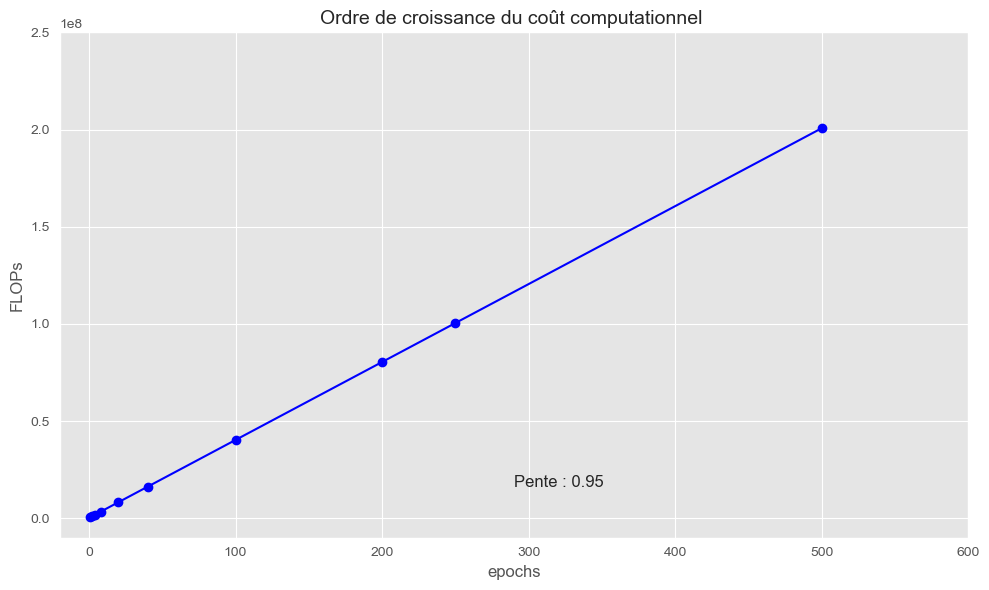

In [57]:
batch_sizes_list = list(results.keys())
flops_values = [results[batch_size]['total_flops'] for batch_size in batch_sizes_list]

# Tracer le coût computatoire en fonction du nombre d'epochs
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes_list, flops_values, marker='o', linestyle='-', color='b')
plt.title("Ordre de croissance du coût computationnel ", fontsize=14)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("FLOPs", fontsize=12)
plt.xlim(-20,600)
plt.ylim(-0.1e08,2.5e08)
log_batch_sizes = np.log(batch_sizes_list)
log_flops_values = np.log(flops_values)
coefficients = np.polyfit(log_batch_sizes, log_flops_values, 1)
slope, intercept = coefficients
plt.text(0.5, 0.1, f"Pente : {slope:.2f}", fontsize=12, transform=plt.gca().transAxes)
plt.grid(True)
plt.tight_layout()
plt.show()

Ce résultat renforce notre intuition, qu'à performances égales, il serait préférable de se tourner vers le batchs-size de petite taille qui auront un coût computationnel moindre. Plus généralement, un batch size de plus petite taille offre également une plus grande capacité à échapper aux minima locaux, sans parler du coût en mémoire.

En tenant compte de ces résultats, l'idée est de savoir comment identifier facilement la taille de batch-size idéale offrant les meilleures performances. L'état actuel de la recherche ne tranche pas la question, 
qui dépend de plusieurs facteurs, notamment le dataset, le modèle, la fonction de perte et les ressources matérielles disponibles.

Il existe néanmoins de règles empiriques ayant montré une certaine efficacité:

- Favoriser les puissance de 2 pour l'exploration

- Une batch-size de départ = $\sqrt{N}$ avec $N$ le nombre d'échantillons, et en restant en dessous de 512.

- Exploration sur un petit nombre d'itérations, en essayant de borner par dichotomie à chaque fois.


Nous pouvons imaginer une fonction qui détermine le batch-size permettant la vitesse de convergence la plus rapide, sur un nombre limité d'iérations, avec des contraintes de limite de variance acceptable, et en appliquant les différentes heuristiques évoquées:

In [60]:
# Fonction de recherche de batch-size idéale qui se sert de règles empiriques citées ci_dessus

def find_optimal_batch_size(X, y, w_random, learning_rate, acceptable_variance=1e-3, max_iterations=100):
    """
    Trouve la taille de batch optimale en explorant les puissances de 2 entre 2 et sqrt(m), par dichotomie.
    Le critère de séléction est la vitesse de réduction de l'erreur

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w_random : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    acceptable_variance : variance acceptable du coût pour considérer la convergence stable
    max_iterations : nombre maximal d'itérations, de mises à jours des poids.

    Returns:
    optimal_batch_size : la taille de batch optimale trouvée
    batch_size_costs : dictionnaire contenant les coûts finaux pour chaque taille de batch testée
    """
    m = len(y)

    # Définir la taille de batch initiale comme la puissance de 2 la plus proche de sqrt(m)
    initial_exponent = int(np.floor(np.log2(np.sqrt(m))))
    initial_batch_size = 2 ** initial_exponent 
    

    # Limites pour la dichotomie
    lower_exponent = 1  # Correspond à une taille de batch de 2^1 = 2
    upper_exponent = initial_exponent

    batch_size_costs = {}

    for iteration in range(max_iterations):
        # Calculer la taille de batch moyenne
        mid_exponent = (lower_exponent + upper_exponent) // 2
        batch_sizes = [2 ** exp for exp in [lower_exponent, mid_exponent, upper_exponent]]
        batch_sizes = sorted(set(batch_sizes))  # Éviter les doublons

        for batch_size in batch_sizes:
            if batch_size in batch_size_costs:
                continue  # Déjà évalué

            # Exécuter la descente de gradient stochastique avec cette taille de batch
            w = w_random.copy()
            num_epochs = batch_size
            w, costs = stochastic_gradient_descent_recherche_optimum(
                X, y, w, learning_rate, num_epochs, batch_size, max_iterations
            )

            # Calculer la variance du coût sur les dernières itérations
            recent_costs = costs[-10:] if len(costs) >= 10 else costs
            cost_variance = np.var(recent_costs)

            # Stocker le coût final et la variance
            batch_size_costs[batch_size] = {
                'final_cost': costs[-1],
                'cost_variance': cost_variance
            }

        # Trouver la taille de batch avec le coût final le plus bas
        optimal_batch_size = min(
            batch_size_costs, key=lambda k: batch_size_costs[k]['final_cost']
        )

        # Vérifier si la variance est acceptable
        if batch_size_costs[optimal_batch_size]['cost_variance'] <= acceptable_variance:
            print(f"Taille de batch optimale trouvée: {optimal_batch_size}")
            break

        # Mise à jour des limites pour la dichotomie
        if optimal_batch_size == 2 ** lower_exponent:
            upper_exponent = mid_exponent - 1
        elif optimal_batch_size == 2 ** upper_exponent:
            lower_exponent = mid_exponent + 1
        else:
            lower_exponent = mid_exponent
            upper_exponent = mid_exponent

        # S'assurer que les exposants restent valides
        lower_exponent = max(lower_exponent, 1)
        upper_exponent = max(upper_exponent, 1)

        if lower_exponent >= upper_exponent:
            print(f"Limite atteinte avec la taille de batch: {optimal_batch_size}")
            break

    return optimal_batch_size, batch_size_costs

def stochastic_gradient_descent_recherche_optimum(X, y, w_random, learning_rate, num_epochs, batch_size=1,max_iterations=100):
   
    m = len(y)  # Nombre total d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy()  # Pour ne pas altérer les poids d'entrée s'il faut les réutiliser

    total_iterations = 0  # Compteur pour le nombre total d'itérations

    for epoch in range(num_epochs):
        # Mélange aléatoire des indices des échantillons
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Parcours des mini-batchs
        for i in range(0, m, batch_size):
            # Vérifier si le nombre maximal d'itérations est atteint
            if total_iterations >= num_epochs * (m // batch_size):
                break

            # Sélection du mini-batch courant
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # Calcul des prédictions pour le mini-batch
            y_pred = predict(X_batch, w)

            # Calcul du gradient pour les poids (sauf le biais) sur le mini-batch
            dw = (1 / len(y_batch)) * np.dot(X_batch.T, (y_pred - y_batch))
            # Calcul du gradient pour le biais sur le mini-batch
            db = (1 / len(y_batch)) * np.sum(y_pred - y_batch)

            # Mise à jour des poids (sauf le biais)
            w[1:] -= learning_rate * dw
            # Mise à jour du biais
            w[0] -= learning_rate * db

            # Calcul et stockage du coût
            cost = cost_function(X, y, w)
            costs.append(cost)

            total_iterations += 1  # Incrémenter le compteur d'itérations
            if total_iterations == max_iterations:
                return w, costs


In [61]:
# paramètres pour le test de notre fonction de recherche du batch-size "optimal" par exploration et heuristiques
np.random.seed(1337)
learning_rate = 0.01
w_init= w.copy()
max_iterations = 100
acceptable_variance = 1e-2

# Lançons notre fonction
optimal_batch_size, batch_size_costs = find_optimal_batch_size(
    X, y, w_init, learning_rate, acceptable_variance, max_iterations
)

print(f"La taille de batch optimale est : {optimal_batch_size}")
print("Détails des coûts pour chaque taille de batch testée :")
for batch_size, info in batch_size_costs.items():
    print(f"Batch size: {batch_size}, Final cost: {info['final_cost']}, Cost variance: {info['cost_variance']}")


Taille de batch optimale trouvée: 4
La taille de batch optimale est : 4
Détails des coûts pour chaque taille de batch testée :
Batch size: 2, Final cost: 3.359615232625512, Cost variance: 0.00010189554194119013
Batch size: 4, Final cost: 3.351880400058261, Cost variance: 0.000100790058968741
Batch size: 16, Final cost: 3.3697241764734964, Cost variance: 6.329222852620533e-05


Notre fonction exécute bien la recherche, elle se fixe une intervalle de puissances de 2, entre 2 et la racine de la taille du dataset, sur lequel elle applique une descente de gradient limitée à 100 mises à jours. Elle vérifie le respect d'une contrainte de variance maximale acceptable chez les prétendants. Pour ensuite rendre un jugement, qui est ici en faveur d'un batch-size de taille 4. Ce résultat est cohérant avec nos résultats précédents. 

Nous pouvons également imaginer divers mécanismes adaptatifs ou le batch-size est ajusté au cours de la descente en fonction de critères de réponse à une anomalie. Par exemple, la fonction suivante implémente un mécanisme simple d'augmentation du batch-size en cas de stagnation de l'erreur pendant plusieurs itérations. La tolérance à l'ampleur de la stagnation et sa durée sont deux paramètres supplémentaires à définir en fonction des données. Le batch-size sera ainsi doublé à chaque anomalie de stagnation rencontrée et ce jusqu'à un seuil maximal:

In [64]:

def stochastic_gradient_descent_batch_adaptive(X, y, w_random, learning_rate, epochs, initial_batch_size=1, max_batch_size=48, patience=1, tolerance=1e-3):
    """
    Implémente l'algorithme de descente de gradient stochastique avec une adaptation dynamique de la taille du batch.
    Le critère est la stagnation de la descente selon une tolérance à son seuil et aux nombres d'itérations stagnantes

    Args:
    X : matrice des caractéristiques (m échantillons x n caractéristiques)
    y : vecteur des étiquettes (m échantillons)
    w : vecteur initial des poids (n+1 dimensions, incluant le biais)
    learning_rate : taux d'apprentissage pour la mise à jour des poids
    epochs : nombre d'époques (passages complets sur les données)
    initial_batch_size : taille de départ des mini-batchs (1 pour SGD pur)
    max_batch_size : taille maximale du batch
    patience : nombre d'époques à attendre avant d'augmenter la taille du batch si amélioration insuffisante
    tolerance : seuil pour juger si l'amélioration du coût est négligeable

    Returns:
    w : vecteur final des poids optimisés
    costs : liste des coûts à intervalles réguliers
    """
    m = len(y)  # Nombre total d'échantillons
    costs = []  # Liste pour stocker l'évolution du coût
    w = w_random.copy() # pour ne pas altérer les poids d'entrée s'il faut les réutiliser
    batch_size = initial_batch_size
    stagnant_iters = 0  # Compteur pour suivre les époques où l'amélioration du coût est faible
    iter_adaption = []
    sizes = []

    for epoch in range(epochs):
        # Mélange aléatoire des indices des échantillons
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Parcours des mini-batchs
        for i in range(0, m, batch_size):
            # Sélection du mini-batch courant
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # Calcul des prédictions pour le mini-batch
            y_pred = predict(X_batch, w)

            # Calcul du gradient pour les poids (sauf le biais) sur le mini-batch
            dw = (1/batch_size) * np.dot(X_batch.T, (y_pred - y_batch))
            # Calcul du gradient pour le biais sur le mini-batch
            db = (1/batch_size) * np.sum(y_pred - y_batch)

            # Mise à jour des poids (sauf le biais)
            w[1:] -= learning_rate * dw
            # Mise à jour du biais
            w[0] -= learning_rate * db

            # Calcul du coût après chaque itération
            cost = cost_function(X, y, w)
            costs.append(cost)

        # Adaptation de la taille du batch si la réduction du coût est faible
            if len(costs) > 1:
                cost_diff = abs(costs[-2] - cost)
                if cost_diff < tolerance:  # Si l'amélioration est inférieure au seuil de tolérance
                    stagnant_iters += 1
                else:
                    stagnant_iters = 0  # Réinitialiser si une amélioration notable est détectée
    
                # Augmenter la taille du batch après un certain nombre d'itérations stagnantes
                if stagnant_iters >= patience and batch_size < max_batch_size:
                    batch_size = min(batch_size * 2, max_batch_size)
                    sizes.append(batch_size)
                    iter_adaption.append(len(costs))
                    stagnant_iters = 0  # Réinitialiser le compteur
                    print(f"Itération {len(costs)}: Augmentation de la taille du batch à {batch_size}")
    
                # Affichage périodique du coût
                if len(costs) % 1000 == 0:
                    print(f"Itération {len(costs)}, Batch Size: {batch_size}, Coût: {cost:.4f}")

    return w, costs, iter_adaption, sizes

Itération 63: Augmentation de la taille du batch à 4
Itération 111: Augmentation de la taille du batch à 8
Itération 121: Augmentation de la taille du batch à 16
Itération 246: Augmentation de la taille du batch à 32
Itération 312: Augmentation de la taille du batch à 64
Itération 332: Augmentation de la taille du batch à 128
Itération 354: Augmentation de la taille du batch à 256
Itération 1000, Batch Size: 256, Coût: 0.0706


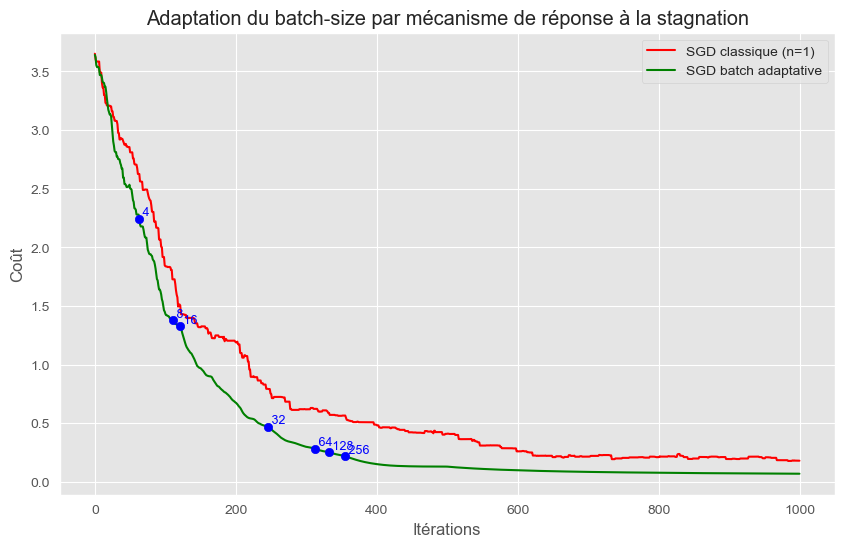

In [65]:
# Paramètres d'essai de la descente de gradient avec batch-size adaptatif
np.random.seed(1337)
w_init=w.copy()
learning_rate=0.1 
epochs=200
initial_batch_size=2
max_batch_size=256
patience=3
tolerance=1e-3

# Appel de la fonction de gradient avec adaptation de la taille du batch                                                           
w_adaptive_batch, costs_adaptive_batch, iters, sizes = stochastic_gradient_descent_batch_adaptive(X, y, w_init,
                                                                                    learning_rate, 
                                                                                    epochs,
                                                                                    initial_batch_size, 
                                                                                    max_batch_size, 
                                                                                    patience, 
                                                                                    tolerance)
# Tracé des coûts
plt.figure(figsize=(10, 6))

# Courbe de coût pour le SGD classique
plt.plot(results[1]["costs"][:1000], label='SGD classique (n=1)', color='red')

# Courbe de coût pour le SGD avec adaptation de la taille du batch
plt.plot(costs_adaptive_batch[:1000], label='SGD batch adaptative', color='green')
for i, iter_change in enumerate(iters):
    plt.scatter(iter_change, costs_adaptive_batch[iter_change], color='blue', zorder=5)
    plt.text(iter_change, costs_adaptive_batch[iter_change], f" {sizes[i]}", 
             fontsize=9, verticalalignment='bottom', horizontalalignment='left', color='blue')

# Titre et légendes
plt.title('Adaptation du batch-size par mécanisme de réponse à la stagnation')
plt.xlabel('Itérations')
plt.ylabel('Coût')
plt.legend()

# Affichage de la courbe
plt.show()

Comme le montre ce graphe, la descente de gradient adaptative, commence par entamer la descente avec un gradient bruité à cause du faible nombre d'échantillons pris en compte dans la mise à jour des poids. Lorsque les mises à jour deviennent trop érratiques et causent une stagnation, l'algorithme réagit en doublant la taille du batch, ce qui a pour effet d'affiner la justesse du gradient et de redynamiser la descente. Au fil des corrections, la stabilité de l'algorithme augmente de plus en plus. Au voisinage du minimum global, une grande taille de batch permet une meilleur approximation du minimum global de la perte empirique. Ici nous atteignons une valeur de 0.07 à la millième itération, avec un batch-size final de 256.

## **Conclusion du Bloc-1**


Dans ce travail, nous avons implémenté et analysé diverses variantes de la descente de gradient appliquées à la régression logistique avec une fonction de perte convexe et lisse. L'étude s'est focalisée sur l'impact du learning-rate et du batch-size sur la convergence des algorithmes d'optimisation.

Pour le learning Rate :

- Un learning rate trop faible entraîne une convergence lente, augmentant le temps de calcul sans garantir l'atteinte rapide du minimum global.

- Un learning rate trop élevé peut provoquer des oscillations ou une divergence de l'algorithme, rendant la convergence instable.

- Des heuristiques empiriques et des bornes théoriques permettent d'approximer des plages de learning-rate acceptable sous certaines conditions.

  
Pour le batch Size :

- Un batch size trop petit peut introduire une variance élevée dans la mise à jour des gradients, entraînant des oscillations et une convergence moins stable.
  
- Augmenter le batch size au-delà d'un certain seuil n'apporte pas d'amélioration significative en termes de vitesse de convergence, tout en augmentant le coût computationnel et les besoins en mémoire.

  
- Des méthodes adaptatives ajustant dynamiquement le batch size en fonction de critères tels que la stagnation de la perte peuvent optimiser la convergence.

La maîtrise du learning rate et du batch size est essentielle pour optimiser l'apprentissage des modèles via la descente de gradient. Un équilibre judicieux entre ces hyperparamètres permet d'accélérer la convergence vers le minimum global de la fonction de perte tout en minimisant le coût computationnel. Les approches adaptatives et les considérations théoriques offrent des pistes prometteuses pour affiner ces paramètres.

Dans la suite du travail en Bloc-2, les différentes descentes de gradient implémentées ci-dessus seront confrontées à un dataset du réel et mises en concurrence avec les implémentations officielles de la régression logistique. Il leur sera demandé de réaliser le même travail, qui sera évalué en fonction des métriques de performance en classification.